In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import warnings
warnings.filterwarnings("ignore") 

In [3]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from scipy.stats import norm

from sklearn.linear_model import LogisticRegression, LinearRegression, SGDRegressor

from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import KNNImputer

from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import r2_score

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# Utill-Class

In [4]:
from scipy.stats import shapiro
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

class EDA:
    # numeric data types
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

    def __init__(self, train_data, test_data, target, skip=None, null_threshold=.6, dup_threshold=.8, corr_threshold=.7, alpha=.05):
        self.train_data = train_data
        self.test_data = test_data
        self.null_threshold = null_threshold
        self.dup_threshold = dup_threshold
        self.corr_threshold = corr_threshold
        self.alpha = alpha
        self.target = target
        self.skip = skip

    # grab numerical data
    def grabNumeric(self, target=True, skip=True):
        numCols = list(set(self.train_data.select_dtypes(include=self.numerics).columns) - set(["Id"]))
        if target == False:
            numCols = list(set(numCols) - set([self.target]))
        if self.skip is not None and skip == True:
            numCols = list(set(numCols) - set(self.skip))
        return numCols

    # grab categorical data
    def grabCategorical(self, target=False):
        catCols = list(set(self.train_data.select_dtypes(include=['object']).columns))
        if target == False:
            catCols = list(set(catCols) - set([self.target]))
        return catCols

    def visualize(self, plot=None, whis=1.5):

        # distribution plot
        if plot == 'dist' or plot is None:
            numCols = self.grabNumeric()
            nR = len(numCols) // 4 if len(numCols) % 4 == 0 else len(numCols) // 4 +1
            fig, axes = plt.subplots(nrows=nR, ncols=4, figsize=(20, nR*6))
            i = 0
            j = 0
            for c in numCols:
                if nR == 1:
                    sns.distplot(x=self.train_data[c], fit=norm, ax=axes[i])
                    axes[i].set_title(c)
                    i += 1
                else:
                    sns.distplot(x=self.train_data[c], fit=norm, ax=axes[i, j])
                    axes[i, j].set_title(c)
                    if j < 3:
                        j +=1
                    else:
                        i += 1
                        j = 0

            fig.suptitle('Distribution of numerical features', fontsize=24, color='darkred')
            fig.tight_layout()
            fig.subplots_adjust(top=0.9)

        # boxplot numerical data
        if plot == 'boxplot' or plot is None:
            numCols = self.grabNumeric()
            nR = len(numCols) // 4 if len(numCols) % 4 == 0 else len(numCols) // 4 +1
            fig, axes = plt.subplots(nrows=nR, ncols=4, figsize=(20, nR*6))
            i = 0
            j = 0
            for c in numCols:
                if nR == 1:
                    sns.boxplot(x=self.train_data[c], orient='h', whis=whis, ax=axes[i])
                    i += 1
                else:
                    sns.boxplot(x=self.train_data[c], orient='h', whis=whis, ax=axes[i, j])
                    if j < 3:
                        j +=1
                    else:
                        i += 1
                        j = 0

            fig.suptitle('Boxplot of numerical features', fontsize=24, color='darkred')
            fig.tight_layout()
            fig.subplots_adjust(top=0.9)
            

        # count plot categorical data
        if plot == 'countplot' or plot is None:
            catCols = self.grabCategorical()
            skipped = []
            if len(catCols) > 0:
                nR = len(catCols) // 4 if len(catCols) % 4 == 0 else len(catCols) // 4 + 1
                fig, axes = plt.subplots(nrows=nR, ncols=4, figsize=(20, nR*6))
                i = 0
                j = 0
                for c in catCols:
                    x = self.train_data[c].value_counts().index
                    y = self.train_data[c].value_counts().values
                    if len(x) > 100:
                        skipped.append(c)
                        continue

                    if nR == 1:
                        sns.barplot(x=x, y=y, data=self.train_data, ax=axes[i])
                        i += 1
                    else:
                        sns.barplot(x=x, y=y, data=self.train_data, ax=axes[i, j])
                        if j < 3:
                            j +=1
                        else:
                            i += 1
                            j = 0
            print("Skipped cols in count plot due to values > 100: \n", skipped)
            fig.suptitle('Countplot of categorical features', fontsize=24, color='darkred')
            fig.tight_layout()
            fig.subplots_adjust(top=0.9)

        # correlation heatmap
        if plot == 'corr' or plot is None:
            CM = self.train_data[self.grabNumeric()].corr()
            CM[(CM < 0.3) & (CM > -0.3)] = 0
            UCM = np.triu(np.ones_like(CM, dtype=bool))
            fig = plt.figure(figsize=(20, 15))
            ax = fig.add_subplot()
            sns.heatmap(data=CM, mask=UCM, ax=ax, annot=True)
            fig.suptitle('Correlation heat map of numerical features', fontsize=24, color='darkred')
            fig.tight_layout()
            fig.subplots_adjust(top=0.9)

    # define nulls
    def grabNulls(self, threshold=None, rthreshold=.1):
        if threshold is not None:
            self.null_threshold = threshold
        m = self.train_data.shape[0]
        null_df = self.train_data.isna().sum().reset_index().rename(columns={0: "Null Count"}).sort_values(by=['Null Count'], ascending=False)
        null_df = null_df[null_df["Null Count"] > 0]
        # columns to be dropped > null_threshold
        CTBD = null_df[null_df['Null Count']/m >= self.null_threshold]
        # rows to be dropped < .1 of samples
        RTBD = null_df[null_df['Null Count']/m <= rthreshold]
        # Records to be filled
        RTBF = null_df[((null_df['Null Count']/m <= self.null_threshold)
                      & (null_df['Null Count']/m > rthreshold))]

        return CTBD, RTBD, RTBF

    def handleNulls(self, threshold=None, rthreshold=.1):
        CTBD, RTBD, RTBF = self.grabNulls(threshold, rthreshold)
        # drop columns with nulls > threshold
        nCols = [s[0] for s in CTBD.values]
        self.train_data = self.train_data.drop(columns=nCols)
        # drop same columns from test data
        if self.test_data is not None:
            self.test_data.drop(columns=nCols, inplace=True)
            self.test_data.dropna(inplace=True)
        # grab cols with rows cotaining nulls in it
        cols = [s[0] for s in RTBD.values]
        # delete records from column with value < .06
        self.train_data = self.train_data.dropna(subset=cols)

        # fill records with mean
        # seperate numeric cols from categorical
        numCols = self.grabNumeric()
        catCols = self.grabCategorical()
        # nurical cols to be filled
        numNull = np.array([])
        # categorical cols to be filled
        catNull = np.array([])
        N = [s[0] for s in RTBF.values]
        for n in N:
            # filter null based on colum type numerical or categorical
            if n in numCols:
                numNull = np.append(numNull, n)
            else:
                catNull = np.append(catNull, n)

        # fill numerical cols with mean
        self.train_data[numNull] = self.train_data[numNull].apply(lambda x: x.fillna(x.mean()))
        # fill categorical cols with mod
        self.train_data[catNull] = self.train_data[catNull].apply(lambda x: x.fillna(x.mode()[0]))

    # duplicated
    def handleDuplicates(self, threshold=None):
        if threshold is not None:
            self.dup_threshold = threshold
        # rows, columns
        m, n = self.train_data.shape
        # list of columns with same value
        dupCol = []
        for c, cData in self.train_data.iteritems():
            if c == self.target or c in self.skip:
                continue
            # Value counts
            VC = any(cData.value_counts().values/m > self.dup_threshold)
            if VC:
                dupCol.append(c)

        self.train_data.drop(columns=dupCol, inplace=True)
        # drop same columns from test data
        if self.test_data is not None:
            self.test_data.drop(columns=dupCol, inplace=True)
        return dupCol

    # correlated features
    def handleCorrFeature(self, threshold=None):
        if threshold is not None:
            self.corr_threshold = threshold
        numCols = [c for c in self.train_data.columns.tolist() if c in self.grabNumeric()]
        CM = self.train_data[numCols].corr()
        # features to be deleted
        redundantFeatures = []
        # correlation values
        corrValues = []
        for index, i in enumerate(numCols):
            # skip target column in the filtering or other custom table
            if i == self.target or i == self.skip:
                continue
            # loop over the upper triangle matrix of the corr matrix since it is symetric
            for j in numCols[index+1:-1]:
                if j == self.skip or j == self.target:
                    continue
                # correlation between 2 features
                cSample = abs(CM.loc[i][j])

                # check for correlation threshold
                if cSample >= self.corr_threshold:
                    # choose which feature is more correlated to target
                    if abs(CM.loc[i][self.target]) > abs(CM.loc[j][self.target]):
                        redundantFeatures.append(j)

                    else:
                        redundantFeatures.append(i)

                    corrValues.append({
                        "Feature correlation":  CM.loc[i][j],
                        f"Feature {i} vs {self.target}":  CM.loc[i][self.target],
                        f"Feature {j} vs {self.target}":  CM.loc[j][self.target],
                    })


        # drop redundant features
        self.train_data.drop(columns=redundantFeatures, inplace=True)
        # drop same columns from test data
        if self.test_data is not None:
            self.test_data.drop(columns=redundantFeatures, inplace=True)
        return redundantFeatures, corrValues


    def checkOutliers(self, threshold=1.5, skip=None):
        numCols = [c for c in self.train_data.columns.tolist() if c in self.grabNumeric(target=False)]
        if skip is not None:
            numCols = list(set(numCols) - set(skip))
        outliers = {}
        for c in self.train_data[numCols]:
            Q1 = self.train_data[c].quantile(.25)
            Q3 = self.train_data[c].quantile(.75)
            IQR = Q3 - Q1
            lower = Q1 - threshold * IQR
            upper = Q3 + threshold * IQR
            # grab rows < lower bound
            LO = self.train_data.index[self.train_data[c] < lower].tolist()
            # grab rows > upper bound
            UO = self.train_data.index[self.train_data[c] > upper].tolist()

            outliers[c] = {
                "Lower Bound": lower,
                "Below Lower": LO,
                "Upper Bound": upper,
                "Above Upper": UO
            }

        return outliers

    # box plot outliers
    def boxplotOutliers(self):
        outliers = list(self.checkOutliers().keys())
        j = 0
        nC = 6
        nR = len(outliers) // nC if len(outliers) % nC == 0 else (len(outliers) // nC) + 1
        if nR == 1:
            fig, axes = plt.subplots(nrows=nR, figsize=(20, 10))
            sns.boxplot(data=self.train_data[outliers])

        else:
            fig, axes = plt.subplots(nrows=nR, figsize=(30, 30))
            for i in range(0, len(outliers), nC):
                sns.boxplot(data=self.train_data[outliers[i:i+nC]], ax=axes[j])
                j += 1


    # hand outliers
    def handleOutliers(self, threshold=1.5, skip=None):
        # grab the outliers
        outliers = self.checkOutliers(threshold)

        for c in outliers:
            if skip is not None:
                if c in skip:
                    continue
            # grab col
            col = outliers[c]
            # if there are values below lower bound
            if len(col['Below Lower']) > 0:
                # replace them with the lower bound
                self.train_data.loc[col['Below Lower'], c] = col['Lower Bound']
            # if there are values above upper bound
            if len(col['Above Upper']) > 0:
                # replace with the upper bound
                self.train_data.loc[col['Above Upper'], c] = col['Upper Bound']

    # check skewness
    def calcSkew(self, target, skip=None):
        n = self.train_data.shape[0]
        numCols = self.grabNumeric(target=target)
        if skip is not None:
            numCols = list(set(numCols) - set(skip))
        mu = self.train_data[numCols].mean()
        std = self.train_data[numCols].std()
        skw = pd.DataFrame(np.sum(np.power((self.train_data[numCols] - mu), 3)) / ((n - 1) * np.power(std, 3)) ).rename(columns={0: "Skew Value"})
        return skw

    # log transformation for skewed features
    def handleSkew(self, target=False, skip=None):
        skw = self.calcSkew(target, skip)
        for s in skw.index.tolist():
            if (skw.loc[s][0] > 1 or skw.loc[s][0] < -1) and skw.loc[s][0] >=0:
                # aplly log transform to column with abs(skewness) > 1 (+, -)
                self.train_data[s] = np.log(1 + abs(self.train_data[s]))
                if self.test_data is not None:
                    self.test_data[s] = np.log(1 + abs(self.test_data[s]))

    # check for normal distributed features
    # draw QQ plot
    def drawQQ(self, target=False, skip=None):
        numCols = self.grabNumeric(target)
        if skip is not None:
            numCols = list(set(numCols) - set(skip))
        nC = 4
        nR = len(numCols) // 4 if len(numCols) % 4 == 0 else (len(numCols) // 4) + 1
        if nR == 1:
            fig, axes = plt.subplots(nrows=nR, ncols=len(numCols), figsize=(20, 10))
        else:
            fig, axes = plt.subplots(nrows=nR, ncols=nC, figsize=(20, nR*15))

        i=0
        j=0
        for col in numCols:
            if nR == 1:
                sm.qqplot(self.train_data[col],fit = False, line='q', ax = axes[j])
                axes[j].set_title(col)
                if(j<nC-1):
                    j+=1
                else:
                    i+=1
                    j=0
            else:
                sm.qqplot(self.train_data[col],fit = False, line='q', ax = axes[i, j])
                axes[i, j].set_title(col)
                if(j<nC-1):
                    j+=1
                else:
                    i+=1
                    j=0
        plt.show();

    # shapiro method
    def checkDistribution(self, threshold=None, target=True, skip=True, skip_c=None):
        if threshold is not None:
            self.alpha = threshold
        numCols = self.grabNumeric(target=target, skip=skip)

        if skip_c is not None:
            numCols = list(set(numCols) - set(skip_c))
        
        # check len of data
        if self.train_data.shape[0] < 500:
            n = self.train_data.shape[0]
        else:
            n = 500
        # list for gaussianFeatures
        gaussianFeatures = []
        # list for nonGaussianFeatures
        nonGaussianFeatures = []
        for c in numCols:
            # calc w and p Statistics for each column
            w_stat, p = shapiro(self.train_data[c].sample(n=n, replace=False))
            print('W_Statistic=%.3f, p=%.8f' % (w_stat, p))

            # if p > alpha add to gaussianFeatures
            if p >= self.alpha:
                print(f'{c} looks like gaussian (fail to reject H0)')
                gaussianFeatures.append(c)

            # if p < alpha add to nongaussianFeatures
            else:
                print(f'{c} does not look Gaussian (reject H0)')
                nonGaussianFeatures.append(c)

        return gaussianFeatures, nonGaussianFeatures


    # scale features
    def featureScale(self, target=False):
        gFeatures, nonGFeatures = self.checkDistribution(target=target)
        # std scale gausian features
        if len(gFeatures) > 0:
            stdScaler = StandardScaler()
            stdScaler = stdScaler.fit(self.train_data[gFeatures])
            self.train_data[gFeatures] = stdScaler.transform(self.train_data[gFeatures])
            if self.test_data is not None:
                self.test_data[gFeatures] = stdScaler.transform(self.test_data[gFeatures])

        # minmax scale non gausian features
        if len(nonGFeatures) > 0:
            mmScaler = MinMaxScaler()
            mmScaler = mmScaler.fit(self.train_data[nonGFeatures])
            self.train_data[nonGFeatures] = mmScaler.transform(self.train_data[nonGFeatures])
            if self.test_data is not None:
                self.test_data[nonGFeatures] = mmScaler.transform(self.test_data[nonGFeatures])

    #split data
    def trainTestSplit(self, test_size, random_state, include=None, exclude=None):
        if include is None and exclude is None:
            numCols = self.grabNumeric(target=False)

        elif include is not None:
            numCols = include

        elif exclude is not None:
            numCols = self.grabNumeric(target=False)
            if exclude in numCols:
                numCols.remove(exclude)
        else:
            numCols = self.grabNumeric(target=False)

        if self.test_data is not None:
            xTrain = self.train_data[numCols]
            yTrain = self.train_data[self.target]
            xTest = self.test_data[numCols]
            yTest = self.test_data[self.target]
            # check gausian and non gausian features
            gFeatures, nonGFeatures = self.checkDistribution()

            if len(gFeatures) > 0:
                stdScaler = StandardScaler()
                stdScaler = stdScaler.fit(xTrain[gFeatures])
                xTrain = stdScaler.transform(xTrain[gFeatures])
                xTest = stdScaler.transform(xTest[gFeatures])

            if len(nonGFeatures) > 0:
                mmScaler = MinMaxScaler()
                mmScaler = mmScaler.fit(xTrain[nonGFeatures])
                xTrain = mmScaler.transform(xTrain[nonGFeatures])
                xTest = mmScaler.transform(xTest[nonGFeatures])

        else:
            xTrain, xTest, yTrain, yTest = train_test_split(self.train_data[numCols],
                                                    self.train_data[self.target],
                                                    test_size=test_size, random_state=random_state)

        return xTrain, xTest, yTrain, yTest


In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

class GradientDescent:
    def __init__(self, data, alpha=.01, gamma=.9, beta1=.9, beta2=.999, e=1e-8):
        self.data = data
        self.alpha = alpha
        self.gamma = gamma
        self.beta1 = beta1
        self.beta2 = beta2
        self.e = e
        self.stepCount = 1
        self.steps = []


    # h(x) = theta0 + theta1 * x1 ....thetan * xn
    """
    x0 = 1
    |1 x1 x2| |theta0|   |y^0|
    |.......| |theta1| = |y^1|
    |.......| |theta2|   |y^2|
    """
    def hypo(self, x0, x):
        hX = x @ x0
        return hX

    # calculate cost
    """
    cost = sum((predicted - y) ** 2) / 2m
    cost = error.T @ error /2m

    error = (predicted - true)
    |y^1|   |y1|   |e1|
    |y^2| - |y2| = |e2|
    |y^3|   |y3|   |e3|

    2/m * |e1 e2 e3| |e1|
                     |e2| = [cost]
                     |e3|

    """

    def CostFunction(self, hX, y):
        error = (hX - y)
        cost = (error.T @ error) /(2*hX.shape[0])
        return cost


    # calculate partial derivative for each parameter
    """
    gradient = (sum(predicted - y) * x)/m
    error = (predicted - true)
    |y^1|   |y1|   |e1|
    |y^2| - |y2| = |e2|
    |y^3|   |y3|   |e3|

    gradient = X.T * error
    |x0 ......| |e1|   |g0|
    |x1 ......| |e2| = |g1|
    |x2 ......| |e3|   |g2|
    """
    def Gradient(self, hX, Y, X):
        m = X.shape[0]
        error = hX - Y
        return (X.T @ error) / m

    def updateTheta(self, x0, gradient, mT=None, vT=None, opt=None, x=None, y=None, stepCount=None):
        # default step(optimizer)
        if opt is None:
            x0 = x0 - (self.alpha * gradient)
            return x0

        # momentum based step
        elif opt == "mT":
            mT = self.gamma * mT + self.alpha * gradient
            x0 = x0 - mT
            return x0, mT

        # Nestrove accelrated gradient
        elif opt == "NAG":
            # calculate theta temp to look in first
            xTemp = x0 - self.gamma * mT
            # evaluate h(x) at theta temp
            hXTemp = self.hypo(xTemp, x)
            # calculate gradient at theta temp
            xTempGrad = self.Gradient(hXTemp, y, x)
            # update theta based on theta temp
            x0 = xTemp - self.alpha * xTempGrad
            mT = self.gamma * mT + self.alpha * xTempGrad

            return x0, mT

        elif opt == "ADGRAD":
            vT = vT + gradient**2
            x0 = x0 - ((self.alpha / (np.sqrt(vT) + self.e)) * gradient)
            return x0, vT

        elif opt == "RMSP":
            vT = self.gamma * vT + (1 - self.gamma) * gradient**2
            x0 = x0 - ((self.alpha / (np.sqrt(vT) + self.e)) * gradient)
            return x0, vT

        elif opt == "ADAM":
            # mt
            mT = self.beta1 * mT + (1 - self.beta1) * gradient
            # vt
            vT = self.beta2 * vT + (1 - self.beta2) * gradient**2
            # bias correction
            mT_ = mT / (1 - np.power(self.beta1, stepCount))
            vT_ = vT / (1 - np.power(self.beta2, stepCount))

            # update the vector
            x0 = x0 - ((self.alpha / (np.sqrt(vT_) + self.e)) * mT_)
            return x0, vT, mT


    #------------------------------------------------#
    def prepareData(self, opt=None, CF=False):
        # shuffle data
        # np.random.shuffle(self.data)
        # self.data.sample(frac=1)
        # inital theta vector
        n = self.data.shape[1]
        x0 = np.zeros((n, 1))
        # create vector column of ones for theta0
        ones = np.ones_like(self.data[:, [0]])
        # build up matrix from x data and ones vector
        X = np.c_[ones, self.data[:, :-1]]
        # true y value is the last column in the data
        Y = self.data[:, [-1]]

        # return X with ones if solving with normal equation
        if CF == True:
            return X, Y

        # Momentum and Nestrov
        if opt == "mT" or opt == "NAG":
            mT = np.zeros_like(x0)
            return X, Y, x0, mT

        # ADAM
        elif opt == "ADAM":
            vT = np.zeros_like(x0)
            mT = np.zeros_like(x0)
            return X, Y, x0, vT, mT

        # ADGRAD and RMSP
        elif opt == "ADGRAD" or opt == "RMSP":
            vT = np.zeros_like(x0)
            return X, Y, x0, vT


        return X, Y, x0


    def fit(self, size=None, opt=None, epochs=None):
        if epochs is None:
            k = 10000
        else:
            k = epochs
        # batch size equall full data if not given
        if size is None:
            size = self.data.shape[0]

        self.stepCount = 1
        self.steps.clear()
        oldCost = None

        # grab the data
        if opt == "mT" or opt == "NAG":
            X, Y, x0, mT = self.prepareData(opt="mT")
        elif opt == "ADGRAD" or opt == "RMSP":
            X, Y, x0, vT = self.prepareData(opt="ADGRAD")
        elif opt == "ADAM":
            X, Y, x0, vT, mT = self.prepareData(opt="ADAM")
        else:
            X, Y, x0 = self.prepareData()

        # number of batches
        nb = self.data.shape[0] // size if self.data.shape[0] % size == 0 else (self.data.shape[0]//size) + 1
        for i in range(0, k):
            bT = 0
            for i in range(0, nb):
                xBatch = X[bT: bT+size, :]
                yBatch = Y[bT: bT+size, :]
                # calculate h(x)
                hX = self.hypo(x0, xBatch)

                # calculate cost
                newCost = self.CostFunction(hX, yBatch)

                # calculate gradient at current x
                gradient = self.Gradient(hX, yBatch, xBatch)
                # update the vector
                if opt == "mT":
                    x0, mT = self.updateTheta(x0, gradient, mT, opt="mT")
                elif opt == "NAG":
                    x0, mT = self.updateTheta(x0, gradient, mT, opt="NAG", x=xBatch, y=yBatch)
                elif opt == "ADGRAD":
                    x0, vT = self.updateTheta(x0, gradient, vT=vT, opt="ADGRAD")
                elif opt == "RMSP":
                    x0, vT = self.updateTheta(x0, gradient, vT=vT, opt="RMSP")
                elif opt == "ADAM":
                    x0, vT, mT = self.updateTheta(x0, gradient, vT=vT, mT=mT, opt="ADAM", stepCount=self.stepCount)
                else:
                    x0 = x0 - (self.alpha * gradient)

                # update step
                self.stepCount +=1

                iterData = {"theta": x0, "cost": newCost, "steps": hX}
                self.steps.append(iterData)

                # update the size
                bT += size

            # break condition "no update in the cost
            if oldCost is not None and abs(newCost - oldCost) <= 1e-5:
                break
            # save the current cost in the oldCost variable
            oldCost = newCost

        if opt is None:
            if size == 1:
                opt = "Stochastic"
            elif size == self.data.shape[0]:
                opt = "Batch GD"
            else:
                opt = "Mini Batch GD"

        plt_hX = self.hypo(x0, X)
        self.plot(opt, size, plt_hX)

    def r2_score(self):
        bf = self.steps[-1]["theta"]
        ones = np.ones((self.data.shape[0], 1))
        M = np.c_[ones, self.data[:, :-1]]
        y_ = M @ bf
        score = r2_score(y_, self.data[:, [-1]])
        return score

    def plot(self, opt, batch, plt_hX):
        x = self.data[:, [0]]
        y = self.data[:, [1]]
        xCost = list(range(len(self.steps)))
        yCost = [s["cost"][0][0] for s in self.steps]
        fig = plt.figure(figsize=(18, 8))


        ax2 = fig.add_subplot(122)
        ax2.plot(xCost, yCost, label="MSE")
        ax2.set_title("MSE vs iterations")
        ax2.set_xlabel("Iteration", fontsize=16).set_color('darkred')
        ax2.set_ylabel("MSE", fontsize=16).set_color('darkred')

        if self.data.shape[1] == 2:
            ax1 = fig.add_subplot(121)
            ax1.scatter(x, y, label="Date point")
            ax1.plot(x, plt_hX, label="Regression Line", color='red')

            ax1.set_xlabel("X", fontsize=16).set_color('darkred')
            ax1.set_ylabel("Y", fontsize=16).set_color('darkred')
            ax1.set_title("Regression Line")
            ax1.grid()
        ax2.grid()
        plt.legend()
        plt.show();
        if opt is None:
            opt = "GD"
        score = self.r2_score()
        print("r2_score: ", score)
        print("Optimizer: ", opt)
        print("Batch size: ", batch)
        print("Total number of iterations: ", self.stepCount - 1)
        print("alpha: ", self.alpha)
        if opt == "ADAM":
            print(f"gamma: {self.gamma} | beta1: {self.beta1} | beta2: {self.beta2}")
        if opt == "RMSP" or opt == "mT" or opt == "NAG":
            print(f"gamma: {self.gamma}")
        # print("Optimal thetas values:\n", self.steps[-1]["theta"])

    # normal equation
    def linear_reg_SVD(self, zero_threshold = 1e-13, with_ones=False):
        if with_ones == True:
            X, Y = self.prepareData(CF=True)
        else:
            X, Y = self.data[:, :-1], self.data[:, [-1]]
        u, s, vT = np.linalg.svd(X, full_matrices= False)

        # Now initialize the "pseudo-"inverse of Sigma, where "pseudo" means "don't divide by zero"
        sigma_pseudo_inverse = np.zeros((vT.shape[0], vT.shape[0]))

        # getting the index of the first approximately zero singular value
        zero_sigma_index= np.where(s <= zero_threshold)

        if len(zero_sigma_index[0]) == 0:
            sigma_pseudo_inverse[:,:] = np.diag(1/s[:])
        else:
            zero_sigma_index = zero_sigma_index[0][0]
            # 1/non-zero diagonal elements calculation
            sigma_pseudo_inverse[:zero_sigma_index,:zero_sigma_index] = np.diag(1/s[ :zero_sigma_index])

        # calculating the optimal coefficients
        optimal_coefficients = vT.T.dot(sigma_pseudo_inverse).dot(u.T).dot(Y)
        return optimal_coefficients


# Read Data

In [6]:
data = pd.read_csv('/content/drive/MyDrive/data_files/weather.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MinTemp        366 non-null    float64
 1   MaxTemp        366 non-null    float64
 2   Rainfall       366 non-null    float64
 3   Evaporation    366 non-null    float64
 4   Sunshine       363 non-null    float64
 5   WindGustDir    363 non-null    object 
 6   WindGustSpeed  364 non-null    float64
 7   WindDir9am     335 non-null    object 
 8   WindDir3pm     365 non-null    object 
 9   WindSpeed9am   359 non-null    float64
 10  WindSpeed3pm   366 non-null    int64  
 11  Humidity9am    366 non-null    int64  
 12  Humidity3pm    366 non-null    int64  
 13  Pressure9am    366 non-null    float64
 14  Pressure3pm    366 non-null    float64
 15  Cloud9am       366 non-null    int64  
 16  Cloud3pm       366 non-null    int64  
 17  Temp9am        366 non-null    float64
 18  Temp3pm   

In [7]:
data.isna().sum()

MinTemp           0
MaxTemp           0
Rainfall          0
Evaporation       0
Sunshine          3
WindGustDir       3
WindGustSpeed     2
WindDir9am       31
WindDir3pm        1
WindSpeed9am      7
WindSpeed3pm      0
Humidity9am       0
Humidity3pm       0
Pressure9am       0
Pressure3pm       0
Cloud9am          0
Cloud3pm          0
Temp9am           0
Temp3pm           0
RainToday         0
RISK_MM           0
RainTomorrow      0
dtype: int64

# EDA

In [8]:
data.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,8.0,24.3,0.0,3.4,6.3,NW,30.0,SW,NW,6.0,20,68,29,1019.7,1015.0,7,7,14.4,23.6,No,3.6,Yes
1,14.0,26.9,3.6,4.4,9.7,ENE,39.0,E,W,4.0,17,80,36,1012.4,1008.4,5,3,17.5,25.7,Yes,3.6,Yes
2,13.7,23.4,3.6,5.8,3.3,NW,85.0,N,NNE,6.0,6,82,69,1009.5,1007.2,8,7,15.4,20.2,Yes,39.8,Yes
3,13.3,15.5,39.8,7.2,9.1,NW,54.0,WNW,W,30.0,24,62,56,1005.5,1007.0,2,7,13.5,14.1,Yes,2.8,Yes
4,7.6,16.1,2.8,5.6,10.6,SSE,50.0,SSE,ESE,20.0,28,68,49,1018.3,1018.5,7,7,11.1,15.4,Yes,0.0,No


In [9]:
data.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RISK_MM
count,366.000000,366.000000,366.000000,366.000000,363.000000,364.000000,359.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000
mean,7.265574,20.550273,1.428415,4.521858,7.909366,39.840659,9.651811,17.986339,72.035519,44.519126,1019.709016,1016.810383,3.890710,4.024590,12.358470,19.230874,1.428415
std,6.025800,6.690516,4.225800,2.669383,3.481517,13.059807,7.951929,8.856997,13.137058,16.850947,6.686212,6.469422,2.956131,2.666268,5.630832,6.640346,4.225800
min,-5.300000,7.600000,0.000000,0.200000,0.000000,13.000000,0.000000,0.000000,36.000000,13.000000,996.500000,996.800000,0.000000,0.000000,0.100000,5.100000,0.000000
25%,2.300000,15.025000,0.000000,2.200000,5.950000,31.000000,6.000000,11.000000,64.000000,32.250000,1015.350000,1012.800000,1.000000,1.000000,7.625000,14.150000,0.000000
50%,7.450000,19.650000,0.000000,4.200000,8.600000,39.000000,7.000000,17.000000,72.000000,43.000000,1020.150000,1017.400000,3.500000,4.000000,12.550000,18.550000,0.000000
75%,12.500000,25.500000,0.200000,6.400000,10.500000,46.000000,13.000000,24.000000,81.000000,55.000000,1024.475000,1021.475000,7.000000,7.000000,17.000000,24.000000,0.200000
max,20.900000,35.800000,39.800000,13.800000,13.600000,98.000000,41.000000,52.000000,99.000000,96.000000,1035.700000,1033.200000,8.000000,8.000000,24.700000,34.500000,39.800000


In [10]:
data['RainTomorrow'].value_counts()

No     300
Yes     66
Name: RainTomorrow, dtype: int64

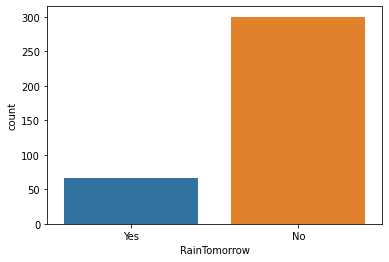

In [11]:
sns.countplot(x=data['RainTomorrow']);

## 1- Split data into train and test

In [12]:
train_data, test_data = train_test_split(data, test_size=.2, random_state=42, stratify=data['RainTomorrow'])

In [13]:
train_data['RainTomorrow'].value_counts()

No     239
Yes     53
Name: RainTomorrow, dtype: int64

In [14]:
test_data['RainTomorrow'].value_counts()

No     61
Yes    13
Name: RainTomorrow, dtype: int64

## 2- Load data in the class

In [15]:
Weather = EDA(train_data=train_data, test_data=test_data, target='RainTomorrow', skip='RainToday')

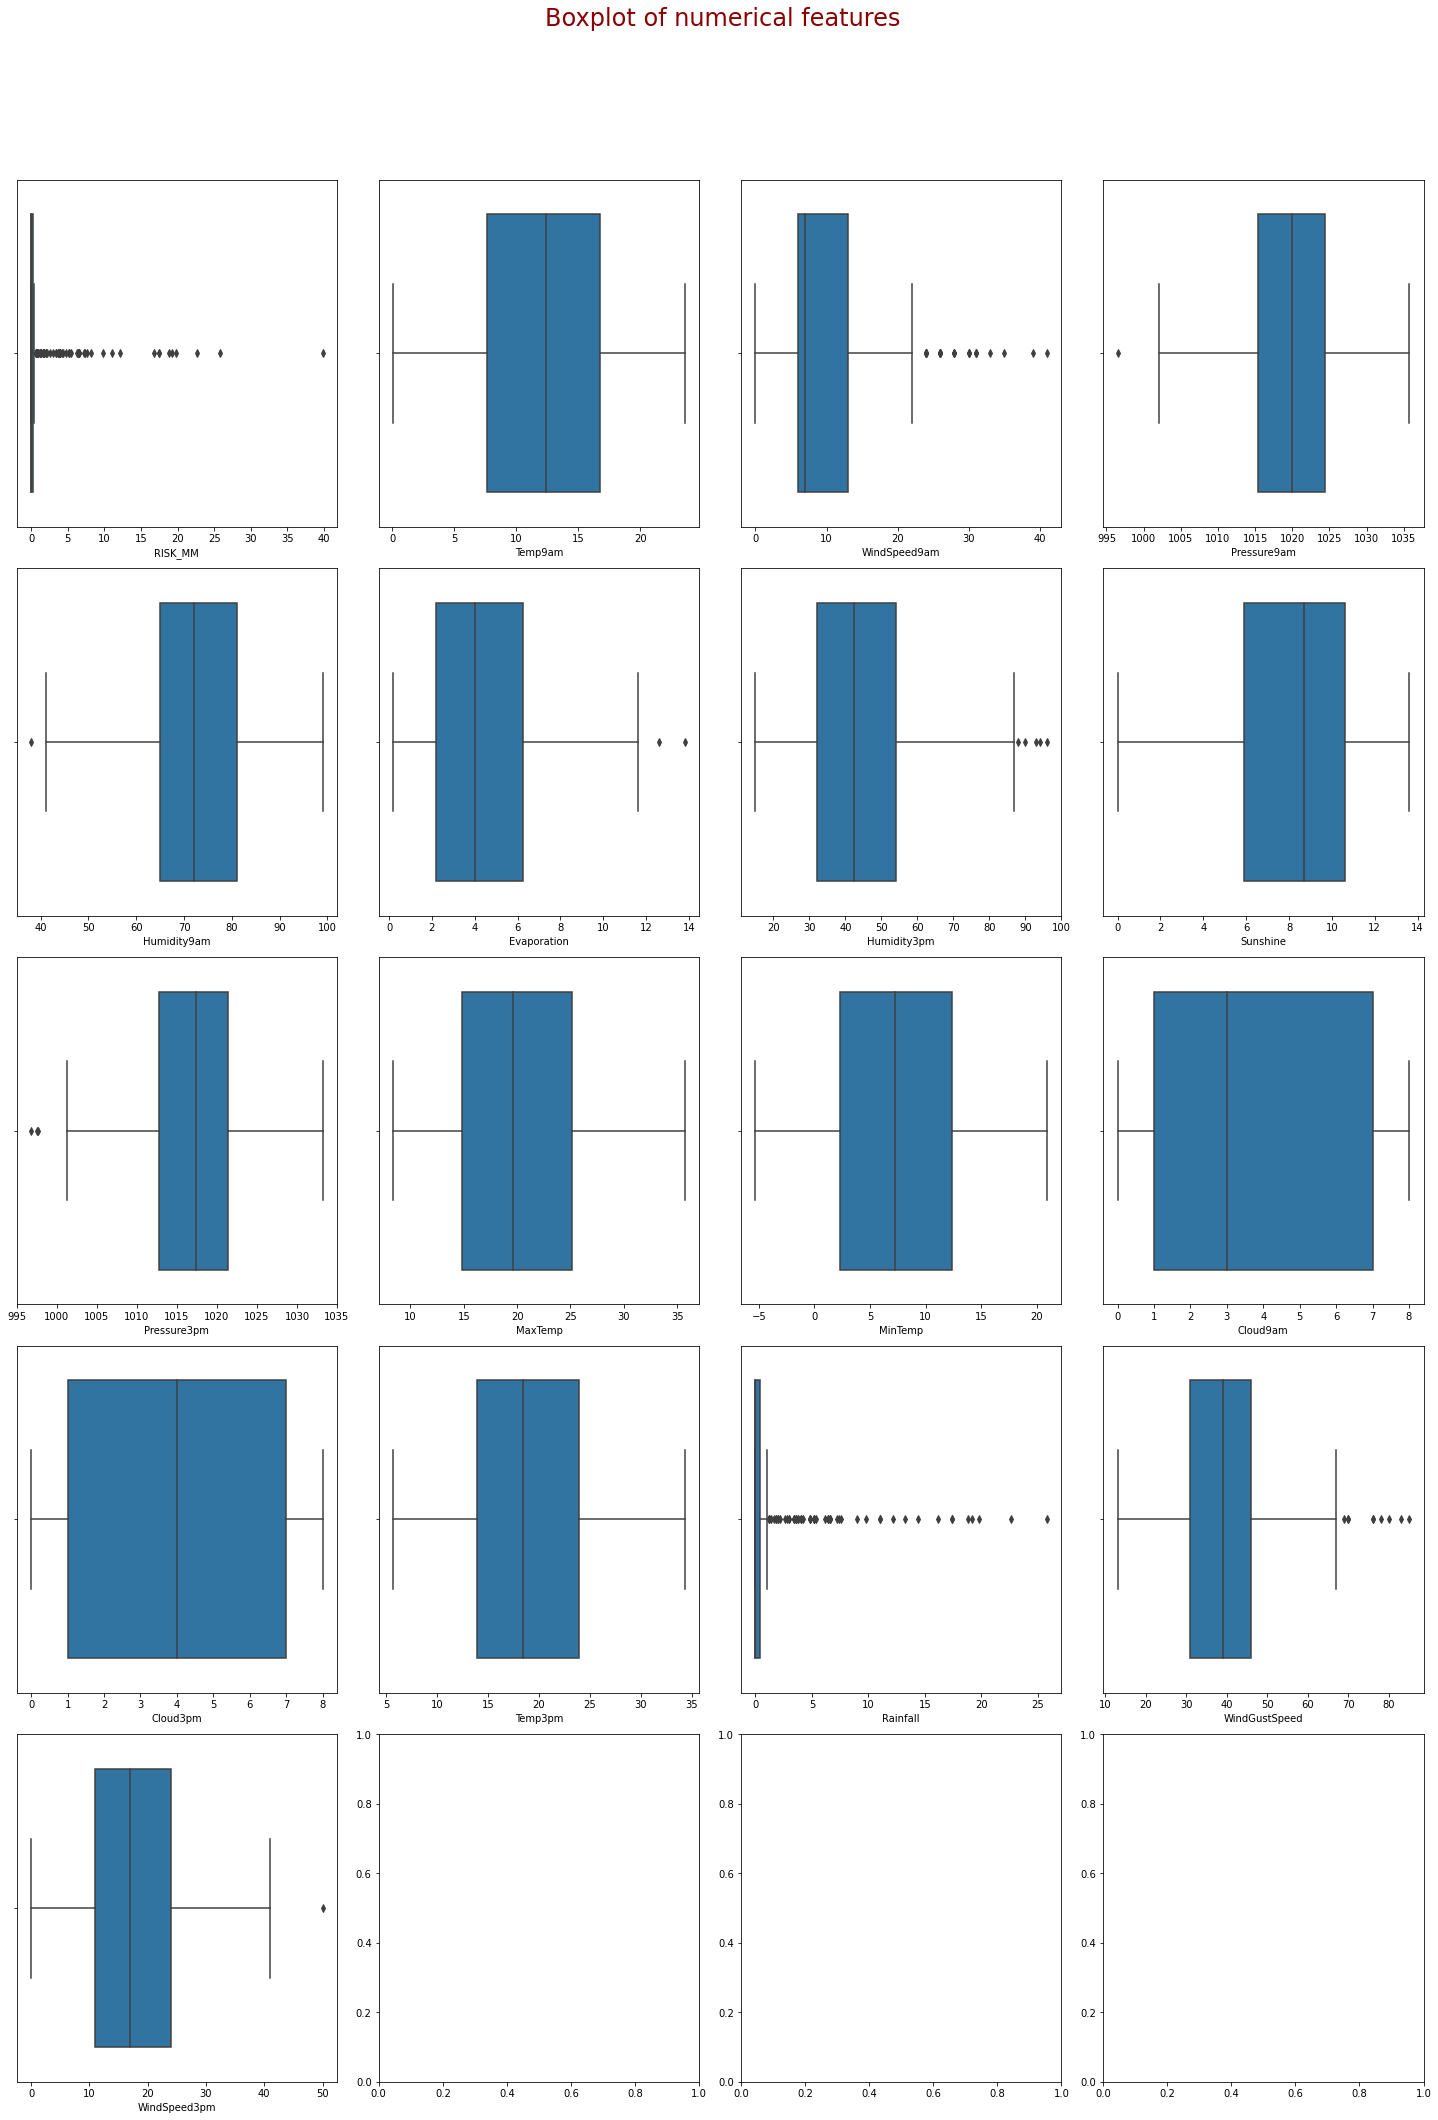

In [16]:
Weather.visualize('boxplot')

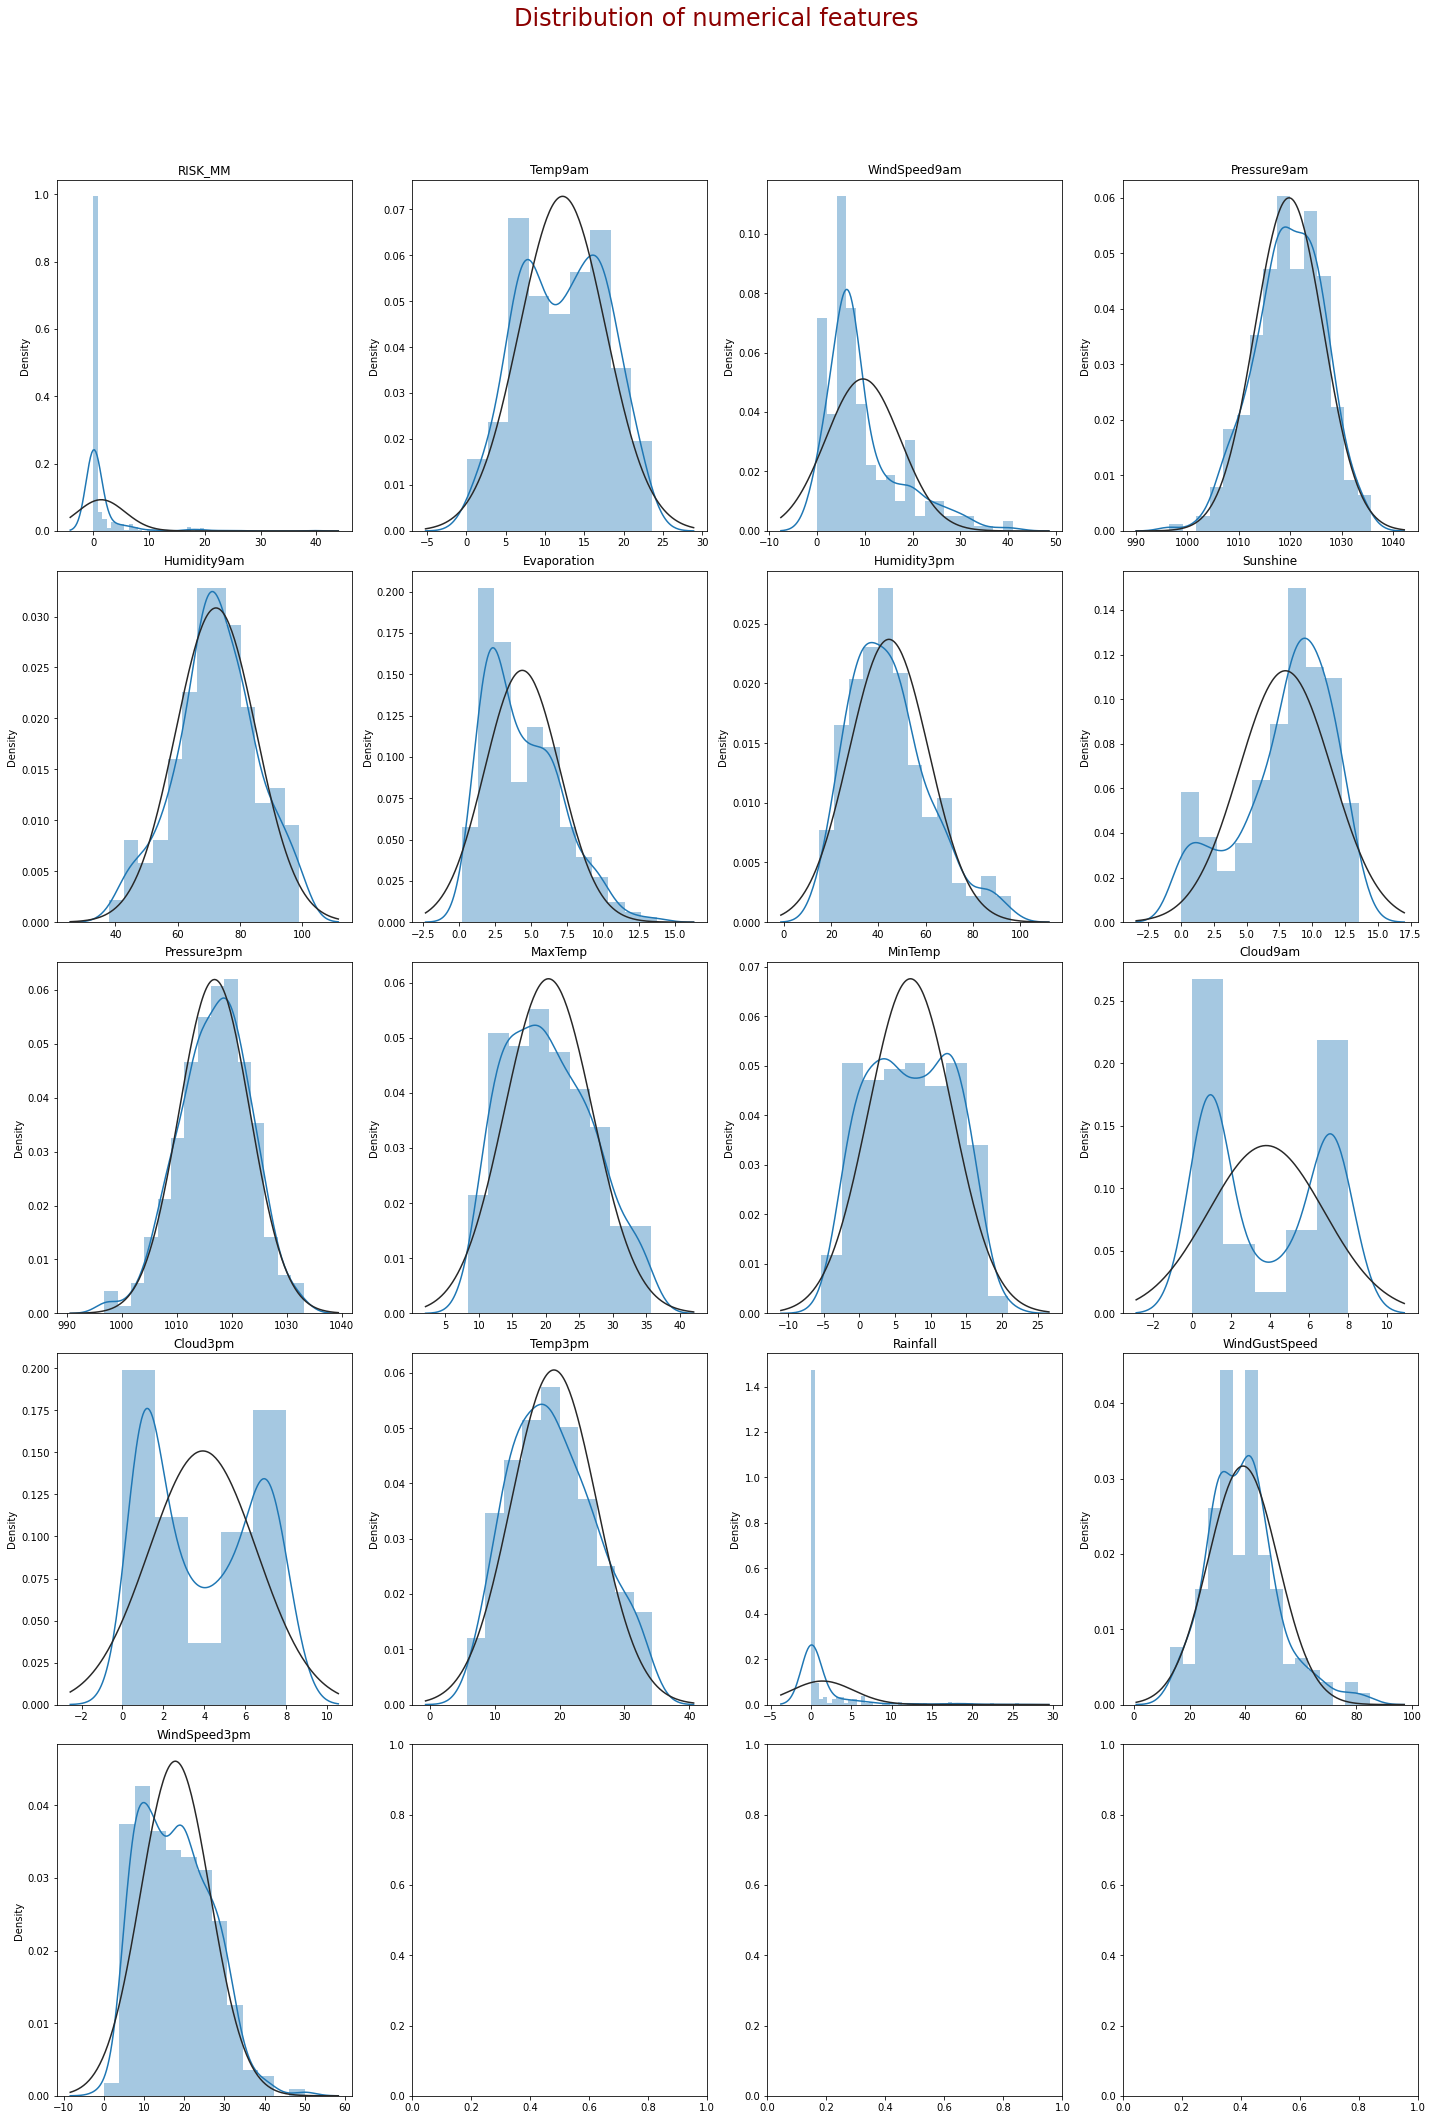

In [17]:
Weather.visualize('dist')

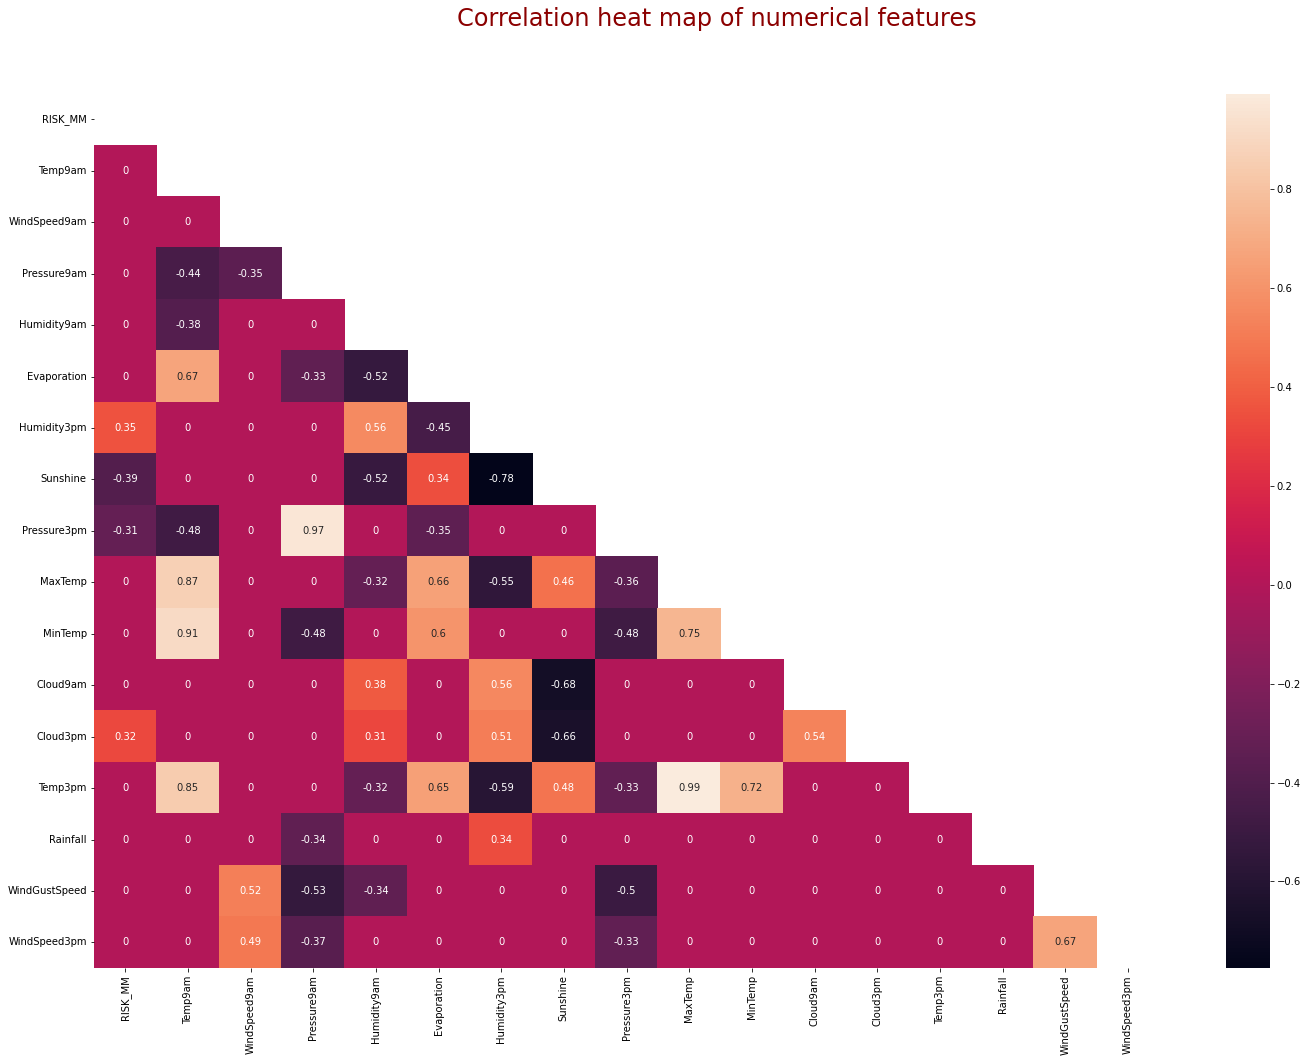

In [18]:
Weather.visualize('corr')

Skipped cols in count plot due to values > 100: 
 []


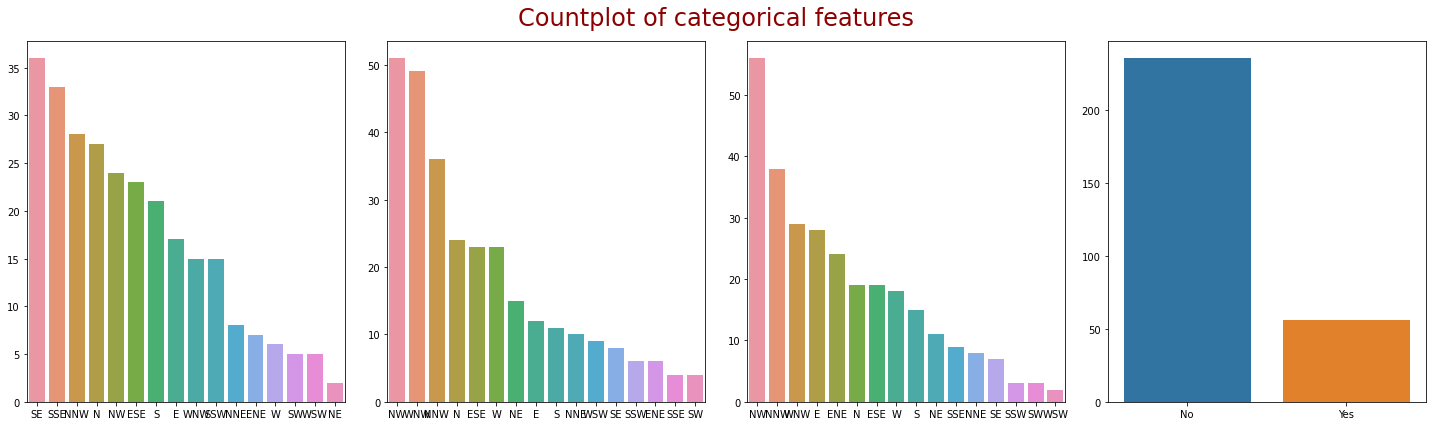

In [19]:
Weather.visualize('countplot')

# Pre-Processing

## Data Pre-processing 
1- Handling Null Values

2- Dropping Features which have more than 80% of values with the same value

3- removing highly correlated features to avoid multi-collinearity as much as we can

4- removing/clamping outliers

5- transforming highly skewed data to reduce their skewness

6- checking for each features whether it follows a normal distribution or not to decide whether to standardize or min-max scale)

7- classify your categorical features into (ordinal and nominal) to decide which features will be label encoded and which features should be OHE

In [20]:
train_data.shape

(292, 22)

## 1- Handling Nulls

In [21]:
Weather.grabNulls()

(Empty DataFrame
 Columns: [index, Null Count]
 Index: [],            index  Null Count
 7     WindDir9am          20
 9   WindSpeed9am           6
 4       Sunshine           3
 5    WindGustDir           3
 6  WindGustSpeed           2
 8     WindDir3pm           1, Empty DataFrame
 Columns: [index, Null Count]
 Index: [])

In [22]:
Weather.handleNulls(rthreshold=.05)

In [23]:
Weather.train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 279 entries, 100 to 156
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MinTemp        279 non-null    float64
 1   MaxTemp        279 non-null    float64
 2   Rainfall       279 non-null    float64
 3   Evaporation    279 non-null    float64
 4   Sunshine       279 non-null    float64
 5   WindGustDir    279 non-null    object 
 6   WindGustSpeed  279 non-null    float64
 7   WindDir9am     279 non-null    object 
 8   WindDir3pm     279 non-null    object 
 9   WindSpeed9am   279 non-null    float64
 10  WindSpeed3pm   279 non-null    int64  
 11  Humidity9am    279 non-null    int64  
 12  Humidity3pm    279 non-null    int64  
 13  Pressure9am    279 non-null    float64
 14  Pressure3pm    279 non-null    float64
 15  Cloud9am       279 non-null    int64  
 16  Cloud3pm       279 non-null    int64  
 17  Temp9am        279 non-null    float64
 18  Temp3pm 

## 2- Handle Duplicates

In [24]:
Weather.handleDuplicates(threshold=.65)

['Rainfall', 'RISK_MM']

## 3- Handle Outliers

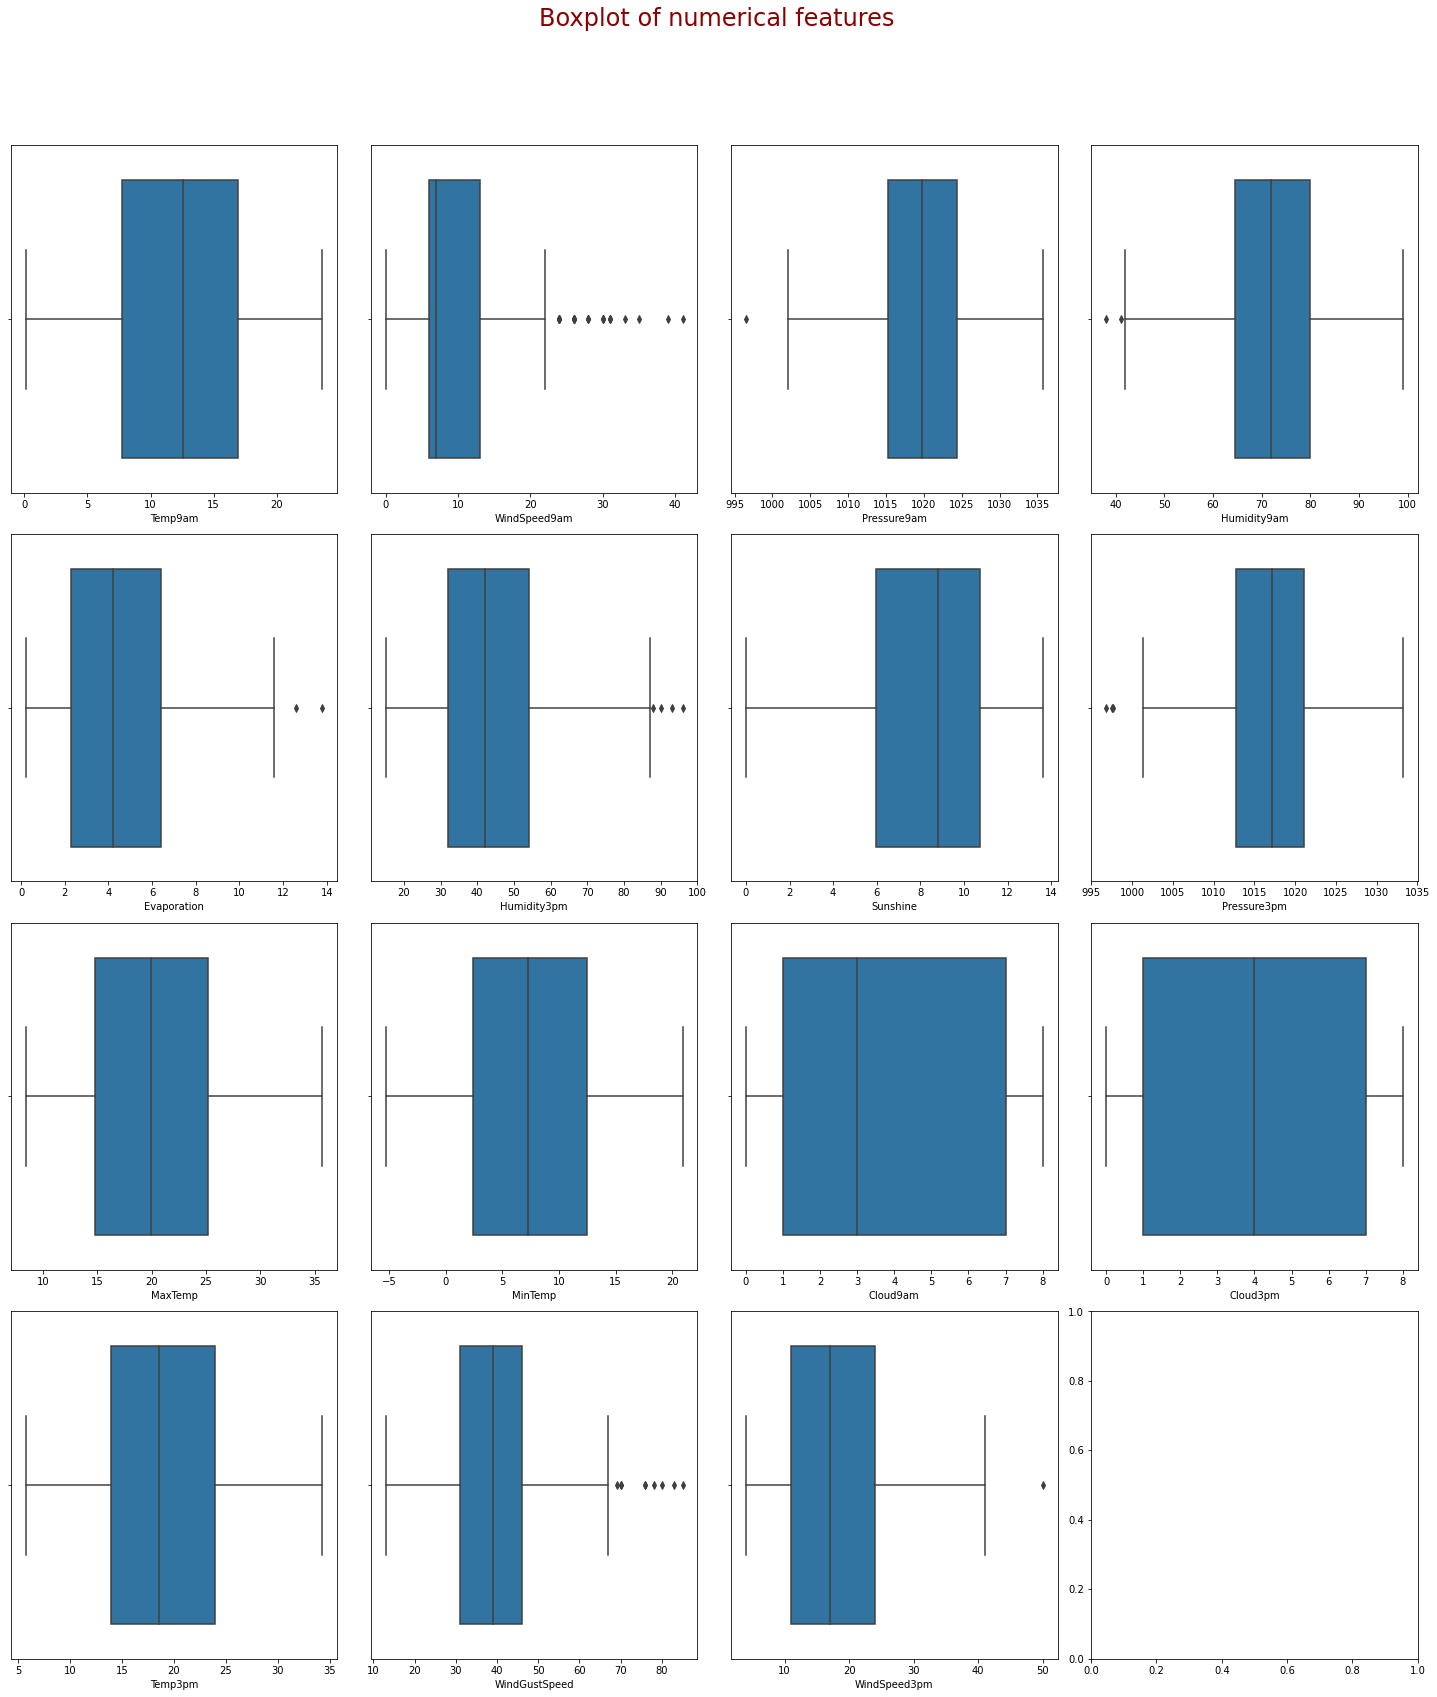

In [25]:
Weather.visualize('boxplot')

In [26]:
outliers = Weather.checkOutliers(threshold=2.5)
outliers

{'Cloud3pm': {'Above Upper': [],
  'Below Lower': [],
  'Lower Bound': -14.0,
  'Upper Bound': 22.0},
 'Cloud9am': {'Above Upper': [],
  'Below Lower': [],
  'Lower Bound': -14.0,
  'Upper Bound': 22.0},
 'Evaporation': {'Above Upper': [],
  'Below Lower': [],
  'Lower Bound': -7.950000000000002,
  'Upper Bound': 16.650000000000002},
 'Humidity3pm': {'Above Upper': [],
  'Below Lower': [],
  'Lower Bound': -23.0,
  'Upper Bound': 109.0},
 'Humidity9am': {'Above Upper': [],
  'Below Lower': [],
  'Lower Bound': 25.75,
  'Upper Bound': 118.75},
 'MaxTemp': {'Above Upper': [],
  'Below Lower': [],
  'Lower Bound': -11.199999999999996,
  'Upper Bound': 51.199999999999996},
 'MinTemp': {'Above Upper': [],
  'Below Lower': [],
  'Lower Bound': -22.724999999999998,
  'Upper Bound': 37.574999999999996},
 'Pressure3pm': {'Above Upper': [],
  'Below Lower': [],
  'Lower Bound': 991.875,
  'Upper Bound': 1041.9750000000001},
 'Pressure9am': {'Above Upper': [],
  'Below Lower': [],
  'Lower Bound'

In [27]:
Weather.train_data[['WindGustSpeed', 'WindSpeed9am']].describe()

,WindGustSpeed,WindSpeed9am
count,279.000000,279.000000
mean,39.544803,9.688172
std,12.567113,7.854768
min,13.000000,0.000000
25%,31.000000,6.000000
50%,39.000000,7.000000
75%,46.000000,13.000000
max,85.000000,41.000000


### Close look at outliers

In [28]:
wind_gust_outliers = outliers['WindGustSpeed']['Above Upper']
print("wind_gust_outliers Upper Bound is: ", outliers['WindGustSpeed']['Upper Bound'])

wind_gust_outliers Upper Bound is:  83.5


In [29]:
Weather.train_data[['WindGustSpeed']].loc[wind_gust_outliers]

,WindGustSpeed
2,85.0


In [30]:
wind_speed_outliers = outliers['WindSpeed9am']['Above Upper']
print("wind_speed_outliers Upper Bound is: ", outliers['WindSpeed9am']['Upper Bound'])

wind_speed_outliers Upper Bound is:  30.5


In [31]:
Weather.train_data[['WindSpeed9am']].loc[wind_speed_outliers]

,WindSpeed9am
337,31.0
356,35.0
51,41.0
244,31.0
318,39.0
243,33.0
252,31.0


> Outliers seem not that extreme so will increase the threshold and remove the extrem ones only

In [32]:
Weather.handleOutliers(threshold=3)

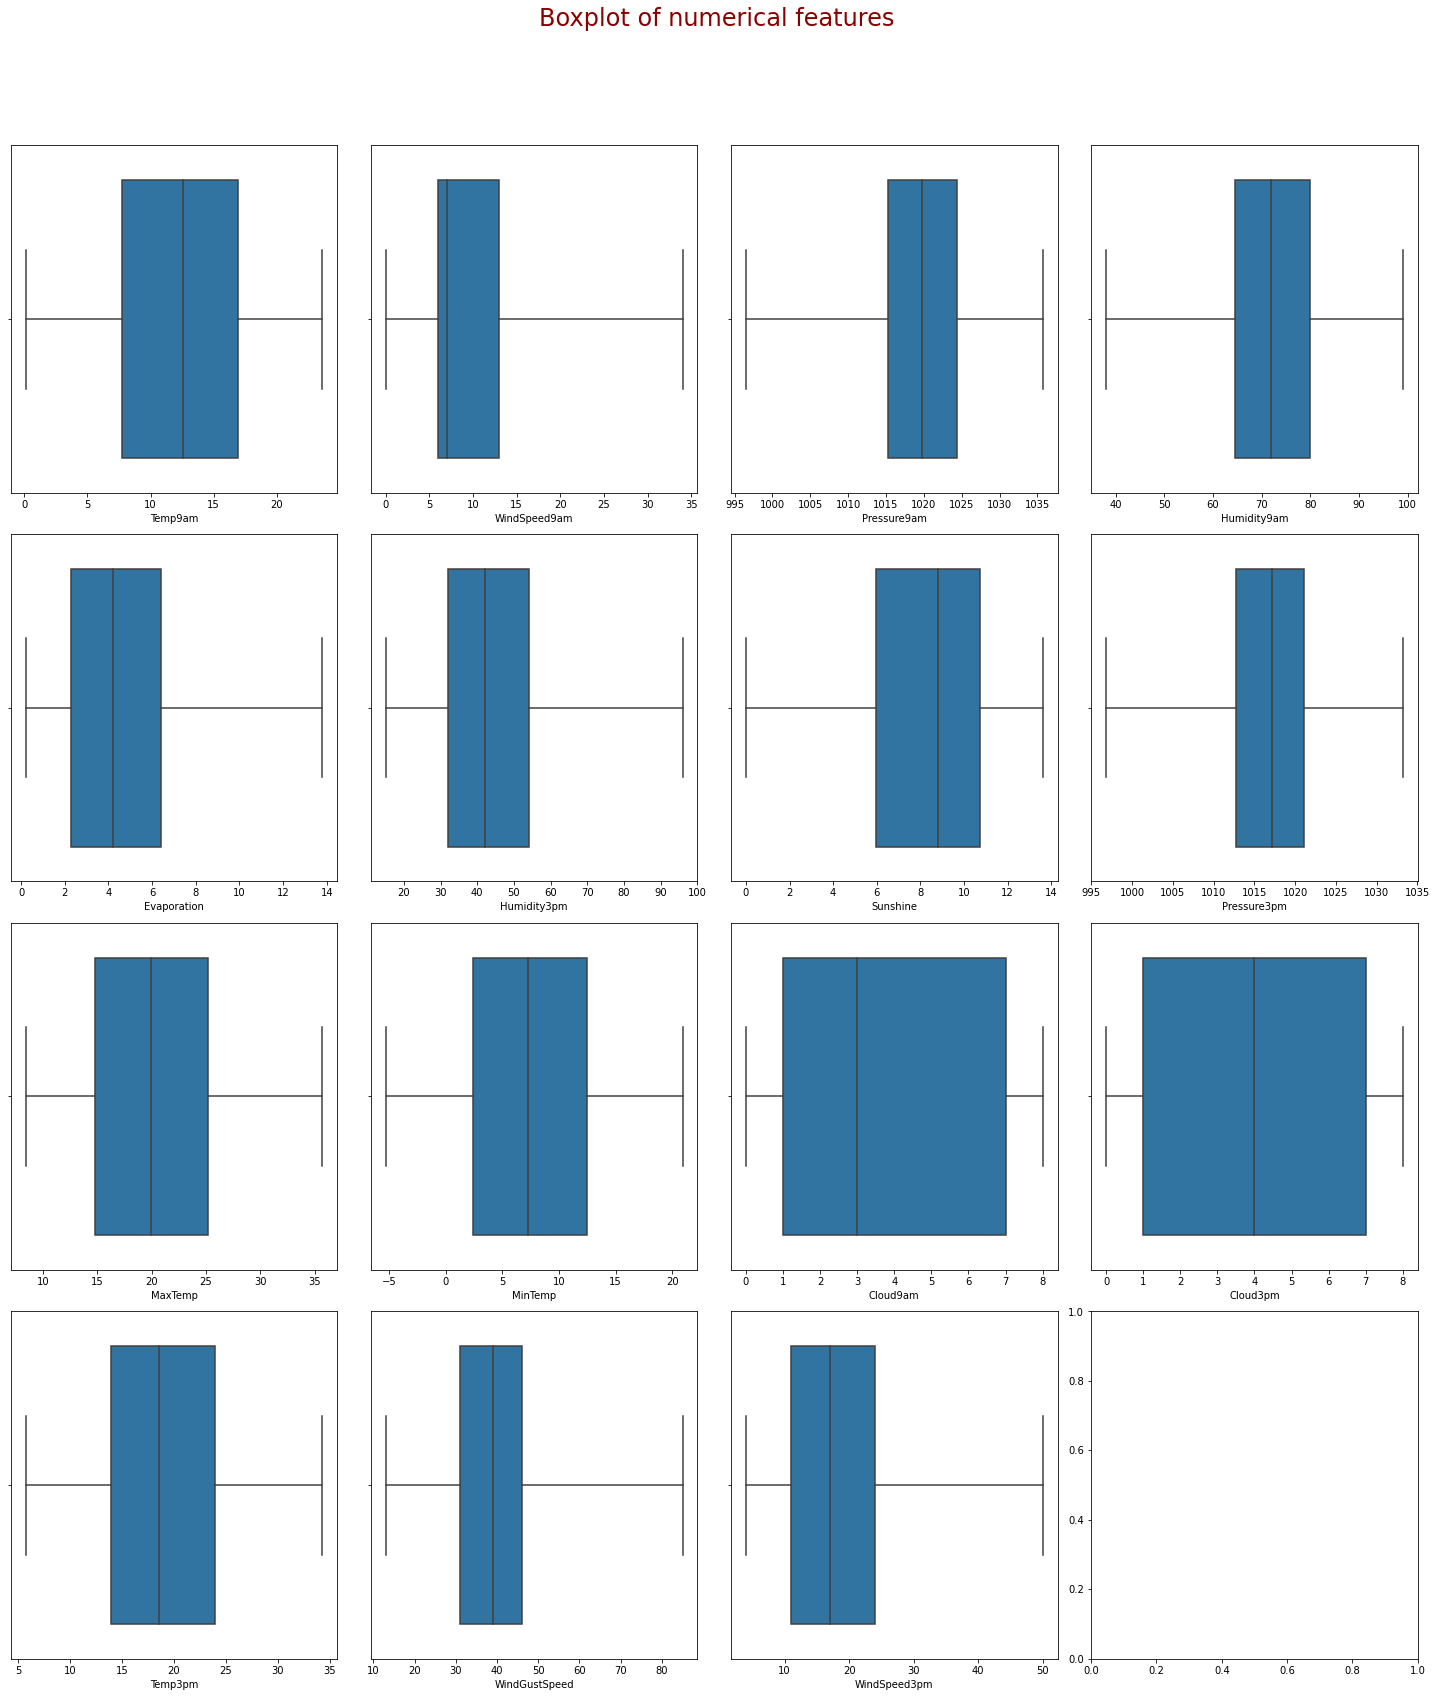

In [33]:
Weather.visualize('boxplot', whis=3)

## 4- Handle Correlation

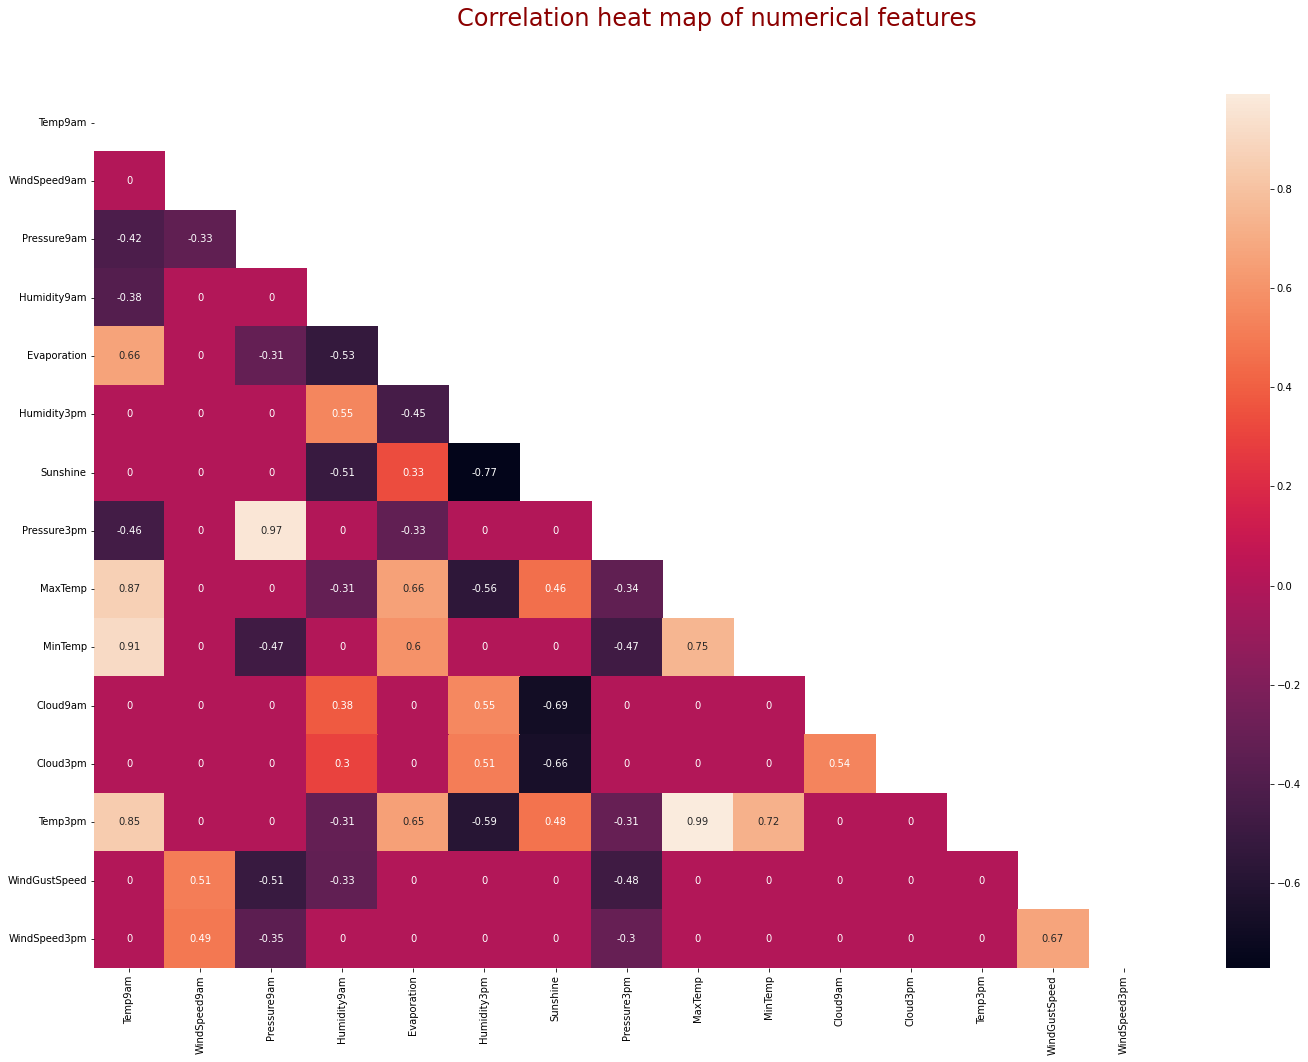

In [34]:
Weather.visualize('corr')

> I don't know a criteria to remove mutlicollinearity with classification as the target is not continuous. will try pca in later stages to over come mutli-collinearity.


1. I can drop one of them randomly and test results










## 5- Handle Skew

In [35]:
Weather.train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 279 entries, 100 to 156
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MinTemp        279 non-null    float64
 1   MaxTemp        279 non-null    float64
 2   Evaporation    279 non-null    float64
 3   Sunshine       279 non-null    float64
 4   WindGustDir    279 non-null    object 
 5   WindGustSpeed  279 non-null    float64
 6   WindDir9am     279 non-null    object 
 7   WindDir3pm     279 non-null    object 
 8   WindSpeed9am   279 non-null    float64
 9   WindSpeed3pm   279 non-null    int64  
 10  Humidity9am    279 non-null    int64  
 11  Humidity3pm    279 non-null    int64  
 12  Pressure9am    279 non-null    float64
 13  Pressure3pm    279 non-null    float64
 14  Cloud9am       279 non-null    int64  
 15  Cloud3pm       279 non-null    int64  
 16  Temp9am        279 non-null    float64
 17  Temp3pm        279 non-null    float64
 18  RainToda

In [36]:
Weather.calcSkew(target=False)

,Skew Value
Temp9am,-0.076586
WindSpeed9am,1.334592
Pressure9am,-0.310459
Humidity9am,-0.125208
Evaporation,0.714109
Humidity3pm,0.703750
Sunshine,-0.758337
Pressure3pm,-0.241393
MaxTemp,0.309754
MinTemp,0.003287


In [37]:
Weather.handleSkew(target=False)

In [38]:
Weather.calcSkew(target=False)

,Skew Value
Temp9am,-0.076586
WindSpeed9am,-0.634846
Pressure9am,-0.310459
Humidity9am,-0.125208
Evaporation,0.714109
Humidity3pm,0.703750
Sunshine,-0.758337
Pressure3pm,-0.241393
MaxTemp,0.309754
MinTemp,0.003287


## 6- Check Distribution

In [39]:
# gaussian feature, non Gaussian features
gaussian, nGaussian = Weather.checkDistribution(target=False)

W_Statistic=0.976, p=0.00014046
Temp9am does not look Gaussian (reject H0)
W_Statistic=0.928, p=0.00000000
WindSpeed9am does not look Gaussian (reject H0)
W_Statistic=0.992, p=0.13748966
Pressure9am looks like gaussian (fail to reject H0)
W_Statistic=0.989, p=0.03255136
Humidity9am does not look Gaussian (reject H0)
W_Statistic=0.950, p=0.00000003
Evaporation does not look Gaussian (reject H0)
W_Statistic=0.962, p=0.00000103
Humidity3pm does not look Gaussian (reject H0)
W_Statistic=0.926, p=0.00000000
Sunshine does not look Gaussian (reject H0)
W_Statistic=0.994, p=0.27564213
Pressure3pm looks like gaussian (fail to reject H0)
W_Statistic=0.973, p=0.00003896
MaxTemp does not look Gaussian (reject H0)
W_Statistic=0.970, p=0.00001357
MinTemp does not look Gaussian (reject H0)
W_Statistic=0.820, p=0.00000000
Cloud9am does not look Gaussian (reject H0)
W_Statistic=0.857, p=0.00000000
Cloud3pm does not look Gaussian (reject H0)
W_Statistic=0.980, p=0.00062802
Temp3pm does not look Gaussian

### Standard scale gaussian features and minmax non gaussian features

In [40]:
Weather.featureScale(target=False)

W_Statistic=0.976, p=0.00014046
Temp9am does not look Gaussian (reject H0)
W_Statistic=0.928, p=0.00000000
WindSpeed9am does not look Gaussian (reject H0)
W_Statistic=0.992, p=0.13748966
Pressure9am looks like gaussian (fail to reject H0)
W_Statistic=0.989, p=0.03255136
Humidity9am does not look Gaussian (reject H0)
W_Statistic=0.950, p=0.00000003
Evaporation does not look Gaussian (reject H0)
W_Statistic=0.962, p=0.00000103
Humidity3pm does not look Gaussian (reject H0)
W_Statistic=0.926, p=0.00000000
Sunshine does not look Gaussian (reject H0)
W_Statistic=0.994, p=0.27564213
Pressure3pm looks like gaussian (fail to reject H0)
W_Statistic=0.973, p=0.00003896
MaxTemp does not look Gaussian (reject H0)
W_Statistic=0.970, p=0.00001357
MinTemp does not look Gaussian (reject H0)
W_Statistic=0.820, p=0.00000000
Cloud9am does not look Gaussian (reject H0)
W_Statistic=0.857, p=0.00000000
Cloud3pm does not look Gaussian (reject H0)
W_Statistic=0.980, p=0.00062802
Temp3pm does not look Gaussian

In [41]:
Weather.train_data[gaussian].describe()

,Pressure9am,Pressure3pm
count,2.790000e+02,2.790000e+02
mean,-6.444865e-15,7.830057e-15
std,1.001797e+00,1.001797e+00
min,-3.528262e+00,-3.151667e+00
25%,-6.564368e-01,-6.233963e-01
50%,4.045945e-02,6.613199e-02
75%,7.373557e-01,7.001810e-01
max,2.475767e+00,2.618179e+00


In [42]:
Weather.train_data[nGaussian].describe()

,Temp9am,WindSpeed9am,Humidity9am,Evaporation,Humidity3pm,Sunshine,MaxTemp,MinTemp,Cloud9am,Cloud3pm,Temp3pm,WindGustSpeed,WindSpeed3pm
count,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000
mean,0.521620,0.591436,0.555849,0.314253,0.360414,0.588657,0.443565,0.480766,0.474014,0.490591,0.473256,0.368678,0.301387
std,0.234030,0.218242,0.212396,0.193335,0.206956,0.261387,0.242471,0.225195,0.373193,0.331179,0.232363,0.174543,0.188189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.325532,0.547319,0.434426,0.154412,0.209877,0.437500,0.234432,0.293893,0.125000,0.125000,0.286713,0.250000,0.152174
50%,0.531915,0.584877,0.557377,0.294118,0.333333,0.647059,0.421245,0.480916,0.375000,0.500000,0.451049,0.361111,0.282609
75%,0.714894,0.742278,0.688525,0.455882,0.481481,0.790441,0.615385,0.677481,0.875000,0.875000,0.639860,0.458333,0.434783
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [43]:
Weather.train_data.head()

,MinTemp,MaxTemp,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
100,0.599237,0.457875,0.279412,0.654412,SSE,0.277778,S,S,0.779836,0.282609,0.442623,0.444444,-1.812825,-1.566544,0.750,0.750,0.582979,0.454545,No,No
94,0.854962,0.776557,0.411765,0.676471,E,0.486111,SE,ESE,0.647640,0.282609,0.475410,0.283951,-0.434349,-0.615471,0.750,0.875,0.919149,0.818182,No,Yes
49,0.683206,0.538462,0.102941,0.169118,NNW,0.236111,N,NW,0.452681,0.195652,0.967213,0.728395,-0.572197,-0.409405,1.000,0.875,0.646809,0.513986,Yes,Yes
316,0.183206,0.483516,0.352941,0.727941,NW,0.486111,NNE,NW,0.647640,0.478261,0.098361,0.148148,-0.755993,-0.916644,0.875,0.625,0.502128,0.552448,No,No
286,0.290076,0.139194,0.191176,0.720588,WNW,0.430556,WNW,NW,0.856322,0.565217,0.327869,0.320988,0.714381,0.906247,0.125,0.125,0.272340,0.164336,No,No


## 7- Categorical Feature encoding

In [44]:
cat_features = Weather.grabCategorical(target=False)
cat_features

['WindDir9am', 'WindDir3pm', 'WindGustDir', 'RainToday']

In [45]:
Weather.train_data['WindDir3pm'].value_counts()

NW     51
WNW    48
NNW    32
ESE    23
N      23
W      21
NE     14
E      12
S      10
NNE    10
WSW     9
SE      7
SSW     6
ENE     5
SSE     4
SW      4
Name: WindDir3pm, dtype: int64

In [46]:
Weather.train_data['WindDir9am'].value_counts()

SE     50
SSE    31
NNW    28
N      26
NW     24
ESE    23
S      20
WNW    15
E      15
SSW    15
NNE     7
ENE     7
W       6
SW      5
WSW     5
NE      2
Name: WindDir9am, dtype: int64

In [47]:
Weather.train_data['WindGustDir'].value_counts()

NW     54
NNW    36
WNW    29
E      28
ENE    24
N      19
ESE    19
W      15
S      15
NE     10
SSE     9
NNE     7
SE      7
SW      3
SSW     2
WSW     2
Name: WindGustDir, dtype: int64

In [48]:
Weather.train_data['RainToday'].value_counts()

No     226
Yes     53
Name: RainToday, dtype: int64

In [49]:
Weather.train_data[['WindGustDir', 'WindDir9am', 'WindDir3pm']].head(10)

,WindGustDir,WindDir9am,WindDir3pm
100,SSE,S,S
94,E,SE,ESE
49,NNW,N,NW
316,NW,NNE,NW
286,WNW,WNW,NW
187,NW,W,NW
148,W,SE,WNW
357,SSE,SSE,S
317,NW,N,NW
337,NNW,NW,NW


> Columns ['WindGustDir', 'WindDir9am', 'WindDir3pm'] seem to hold almost same value with different detail level so i will keep ['WindGustDir'] and remove other 2 columns

In [50]:
Weather.train_data['WindGustDir']

100    SSE
94       E
49     NNW
316     NW
286    WNW
      ... 
183      W
164      W
208    NNW
305     NW
156      E
Name: WindGustDir, Length: 279, dtype: object

In [51]:
# OneHotEncode
OHE = OneHotEncoder(sparse=False)
OHE = OHE.fit(Weather.train_data[['WindGustDir']])
OHE_train = OHE.transform(Weather.train_data[['WindGustDir']])
OHE_test = OHE.transform(Weather.test_data[['WindGustDir']])

In [52]:
# Ordinal Categories
train_ORD = Weather.train_data[['RainTomorrow']].replace({'No': 0, 'Yes': 1})
test_ORD = Weather.test_data[['RainTomorrow']].replace({'No': 0, 'Yes': 1})


## Train Data

In [53]:
cols = Weather.grabNumeric() + OHE.get_feature_names_out().tolist() + ['RainTomorrow']

In [54]:
train_num_cols = Weather.train_data[Weather.grabNumeric()].values
train_D = np.c_[train_num_cols, OHE_train, train_ORD]
final_train = pd.DataFrame(train_D, columns=cols)

In [55]:
final_train.shape

(279, 32)

## Test Data

In [56]:
test_num_cols = Weather.test_data[Weather.grabNumeric()].values
test_D = np.c_[test_num_cols, OHE_test, test_ORD]
final_test = pd.DataFrame(test_D, columns=cols)

In [57]:
final_test.shape

(63, 32)

# Model Testing

In [58]:
Train_x = final_train.drop(columns='RainTomorrow')
Train_y = final_train['RainTomorrow']

In [59]:
Test_x = final_test.drop(columns='RainTomorrow')
Test_y = final_test['RainTomorrow']

## Visualize class distribution

In [60]:
from sklearn.decomposition import PCA

pca = PCA(2)
x_new = pca.fit_transform(Train_x)

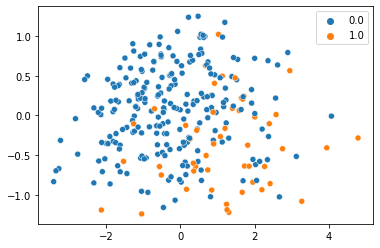

In [61]:
sns.scatterplot(x=x_new[:, 0], y=x_new[:, 1], hue=Train_y.values.ravel());

In [62]:
from sklearn.manifold import TSNE

In [63]:
scaled_train = StandardScaler().fit(Train_x)

In [64]:
X_embded = TSNE(n_components=2, learning_rate='auto', perplexity=100, init='random').fit_transform(Train_x)

In [65]:
x = X_embded[:, 0]
y = X_embded[:, 1]

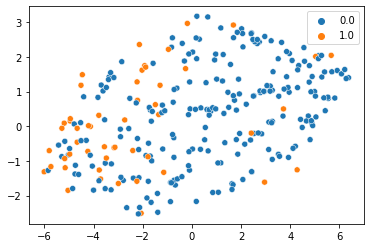

In [66]:
sns.scatterplot(x=x, y=y, hue=Train_y.values.ravel());

## Evaluation Metric

In [67]:
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import plot_roc_curve, plot_confusion_matrix

> Since we are predicting whether it will be rainning tomorrow or not then: 

*   Precision means how many days it will rain from the total number of days we predicted to be raining  
*   Recall means how many raining days we actually were able to predict as will be rainning

In this problem we are more interested in Recall as we want to predict as many rainning days as we can but also want our precision to be good not to say every day it will be raining and acheive 1 Recall.
F1-Score is a good measure to handle both cases Recall and trade off with Precision. But since target label is unblanced in the test set i will be using AUC as final judge.

## 1- Logistic Regression

### 1.1 Data with no PCA

In [68]:
Test_x.shape

(63, 31)

In [69]:
Train_results = pd.DataFrame(columns=['C', 'Fit_Intercept', 'Class_weight', 'Precision', 'Recall', 'F1-Score', 'Accuracy'])

In [70]:
Test_results = pd.DataFrame(columns=['C', 'Fit_Intercept', 'Class_weight', 'Precision', 'Recall', 'F1-Score', 'Accuracy'])

In [71]:
C = [.001, .01, .1, 1, 2, 3, 4, 10, 11, 12, 13, 14, 15]

for c in C:
    LR_Search = LogisticRegression(C=c, class_weight='balanced', max_iter=1000, fit_intercept=False)
    LR_Search.fit(Train_x, Train_y)

    # train y pred
    y_train_pred = LR_Search.predict(Train_x)

    # test y pred
    y_test_pred = LR_Search.predict(Test_x)

    # Precision
    train_precision = precision_score(Train_y, y_train_pred)
    test_precision = precision_score(Test_y, y_test_pred)

    # Recall
    train_recall = recall_score(Train_y, y_train_pred)
    test_recall = recall_score(Test_y, y_test_pred)

    # F1 score
    train_f1 = f1_score(Train_y, y_train_pred)
    test_f1 = f1_score(Test_y, y_test_pred)

    # Accuracy
    train_accuracy = accuracy_score(Train_y, y_train_pred)
    test_accuracy = accuracy_score(Test_y, y_test_pred)

    # append train results to train results df
    Train_results.loc[-1] = [c, True, 'Balanced', train_precision, train_recall, train_f1, train_accuracy]
    Train_results.index = Train_results.index + 1  # shifting index
    Train_results = Train_results.sort_index()

    # append test results to test results df
    Test_results.loc[-1] = [c, True, 'Balanced', test_precision, test_recall, test_f1, test_accuracy]
    Test_results.index = Test_results.index + 1  # shifting index
    Test_results = Test_results.sort_index()


In [72]:
Train_results.sort_values(['F1-Score', 'Precision'], ascending=False).head()

,C,Fit_Intercept,Class_weight,Precision,Recall,F1-Score,Accuracy
0,15.0,True,Balanced,0.661765,0.882353,0.756303,0.896057
1,14.0,True,Balanced,0.652174,0.882353,0.750000,0.892473
2,13.0,True,Balanced,0.652174,0.882353,0.750000,0.892473
3,12.0,True,Balanced,0.642857,0.882353,0.743802,0.888889
4,11.0,True,Balanced,0.628571,0.862745,0.727273,0.881720


In [73]:
Test_results.sort_values(['F1-Score', 'Precision'], ascending=False).head()

,C,Fit_Intercept,Class_weight,Precision,Recall,F1-Score,Accuracy
0,15.0,True,Balanced,0.5,0.916667,0.647059,0.809524
1,14.0,True,Balanced,0.5,0.916667,0.647059,0.809524
2,13.0,True,Balanced,0.5,0.916667,0.647059,0.809524
3,12.0,True,Balanced,0.5,0.916667,0.647059,0.809524
4,11.0,True,Balanced,0.5,0.916667,0.647059,0.809524


> Best Model ROC

In [74]:
LR_model = LogisticRegression(C=15, class_weight='balanced', max_iter=1000, fit_intercept=True)
LR_model.fit(Train_x, Train_y)

LogisticRegression(C=15, class_weight='balanced', max_iter=1000)

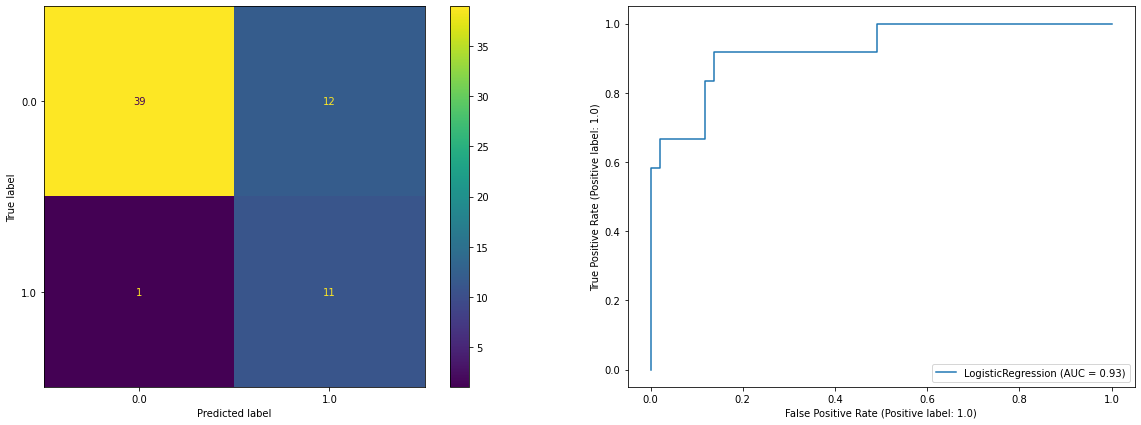

In [75]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))
plot_confusion_matrix(LR_model, Test_x, Test_y, ax=axes[0])
plot_roc_curve(LR_model, Test_x, Test_y, ax=axes[1]);

### 1.2 PCA

In [76]:
from sklearn.decomposition import PCA

In [77]:
pca = PCA(.9)
pca.fit(Train_x)
pca.n_components_

12

In [78]:
pca_train_x = pca.transform(Train_x)
pca_test_x = pca.transform(Test_x)

In [79]:
pca_Train_results = pd.DataFrame(columns=['C', 'Fit_Intercept', 'Class_weight', 'Precision', 'Recall', 'F1-Score', 'Accuracy'])

In [80]:
pca_Test_results = pd.DataFrame(columns=['C', 'Fit_Intercept', 'Class_weight', 'Precision', 'Recall', 'F1-Score', 'Accuracy'])

In [81]:
C = [.001, .01, .1, 1, 2, 3, 4, 10, 11, 12, 13, 14, 15]

for c in C:
    pca_LR_Search = LogisticRegression(C=c, class_weight='balanced', max_iter=1000, fit_intercept=False)
    pca_LR_Search.fit(pca_train_x, Train_y)

    # train y pred
    pca_y_train_pred = pca_LR_Search.predict(pca_train_x)

    # test y pred
    pca_y_test_pred = pca_LR_Search.predict(pca_test_x)

    # Precision
    pca_train_precision = precision_score(Train_y, pca_y_train_pred)
    pca_test_precision = precision_score(Test_y, pca_y_test_pred)

    # Recall
    pca_train_recall = recall_score(Train_y, pca_y_train_pred)
    pca_test_recall = recall_score(Test_y, pca_y_test_pred)

    # F1 score
    pca_train_f1 = f1_score(Train_y, pca_y_train_pred)
    pca_test_f1 = f1_score(Test_y, pca_y_test_pred)

    # Accuracy
    pca_train_accuracy = accuracy_score(Train_y, pca_y_train_pred)
    pca_test_accuracy = accuracy_score(Test_y, pca_y_test_pred)

    # append train results to train results df
    pca_Train_results.loc[-1] = [c, True, 'Balanced', pca_train_precision, pca_train_recall, pca_train_f1, pca_train_accuracy]
    pca_Train_results.index = pca_Train_results.index + 1  # shifting index
    pca_Train_results = pca_Train_results.sort_index()

    # append test results to test results df
    pca_Test_results.loc[-1] = [c, True, 'Balanced', pca_test_precision, pca_test_recall, pca_test_f1, pca_test_accuracy]
    pca_Test_results.index = pca_Test_results.index + 1  # shifting index
    pca_Test_results = pca_Test_results.sort_index()


In [82]:
pca_Train_results.sort_values(['F1-Score', 'Precision'], ascending=False).head()

,C,Fit_Intercept,Class_weight,Precision,Recall,F1-Score,Accuracy
7,3.0,True,Balanced,0.370968,0.901961,0.525714,0.702509
8,2.0,True,Balanced,0.370968,0.901961,0.525714,0.702509
9,1.0,True,Balanced,0.370968,0.901961,0.525714,0.702509
0,15.0,True,Balanced,0.368000,0.901961,0.522727,0.698925
1,14.0,True,Balanced,0.368000,0.901961,0.522727,0.698925


In [83]:
pca_Test_results.sort_values(['F1-Score', 'Precision'], ascending=False).head()

,C,Fit_Intercept,Class_weight,Precision,Recall,F1-Score,Accuracy
9,1.0,True,Balanced,0.413793,1.0,0.585366,0.730159
0,15.0,True,Balanced,0.400000,1.0,0.571429,0.714286
1,14.0,True,Balanced,0.400000,1.0,0.571429,0.714286
2,13.0,True,Balanced,0.400000,1.0,0.571429,0.714286
3,12.0,True,Balanced,0.400000,1.0,0.571429,0.714286


> ## PCA didn't give better results

## 2- SVC

In [84]:
from sklearn.svm import SVC

In [85]:
svc_Train_results = pd.DataFrame(columns=['Kernel', 'C', 'Degree', 'Gamma', 'Precision', 'Recall', 'F1-Score', 'Accuracy'])

In [86]:
svc_Test_results = pd.DataFrame(columns=['Kernel', 'C', 'Degree', 'Gamma', 'Precision', 'Recall', 'F1-Score', 'Accuracy'])

In [87]:
C = [.001, .01, .1, 1, 2, 3, 4, 10, 11, 12, 13, 14, 15]
degree = [2, 3, 4, 5, 6]
gamma = [.001, .01, .1, 1, 10]
kernel = ['rbf', 'poly', 'linear']


for k in kernel:
    if k == 'rbf':
        for c in C:
            for g in gamma:
                svc = SVC(class_weight='balanced', C=c, gamma=g, kernel=k)
                svc.fit(Train_x, Train_y)

                # train y pred
                svc_y_train_pred = svc.predict(Train_x)

                # test y pred
                svc_y_test_pred = svc.predict(Test_x)

                # Precision
                svc_train_precision = precision_score(Train_y, svc_y_train_pred)
                svc_test_precision = precision_score(Test_y, svc_y_test_pred)

                # Recall
                svc_train_recall = recall_score(Train_y, svc_y_train_pred)
                svc_test_recall = recall_score(Test_y, svc_y_test_pred)

                # F1 score
                svc_train_f1 = f1_score(Train_y, svc_y_train_pred)
                svc_test_f1 = f1_score(Test_y, svc_y_test_pred)

                # Accuracy
                svc_train_accuracy = accuracy_score(Train_y, svc_y_train_pred)
                svc_test_accuracy = accuracy_score(Test_y, svc_y_test_pred)

                # append train results to train results df
                svc_Train_results.loc[-1] = [k, c, -1, g, svc_train_precision, svc_train_recall, svc_train_f1, svc_train_accuracy]
                svc_Train_results.index = svc_Train_results.index + 1  # shifting index
                svc_Train_results = svc_Train_results.sort_index()

                # append test results to test results df
                svc_Test_results.loc[-1] = [k, c, -1, g, svc_test_precision, svc_test_recall, svc_test_f1, svc_test_accuracy]
                svc_Test_results.index = svc_Test_results.index + 1  # shifting index
                svc_Test_results = svc_Test_results.sort_index()
    elif k == 'linear':
        for c in C:
            svc = SVC(class_weight='balanced', C=c, kernel=k)
            svc.fit(Train_x, Train_y)

            # train y pred
            svc_y_train_pred = svc.predict(Train_x)

            # test y pred
            svc_y_test_pred = svc.predict(Test_x)

            # Precision
            svc_train_precision = precision_score(Train_y, svc_y_train_pred)
            svc_test_precision = precision_score(Test_y, svc_y_test_pred)

            # Recall
            svc_train_recall = recall_score(Train_y, svc_y_train_pred)
            svc_test_recall = recall_score(Test_y, svc_y_test_pred)

            # F1 score
            svc_train_f1 = f1_score(Train_y, svc_y_train_pred)
            svc_test_f1 = f1_score(Test_y, svc_y_test_pred)

            # Accuracy
            svc_train_accuracy = accuracy_score(Train_y, svc_y_train_pred)
            svc_test_accuracy = accuracy_score(Test_y, svc_y_test_pred)

            # append train results to train results df
            svc_Train_results.loc[-1] = [k, c, -1, -1, svc_train_precision, svc_train_recall, svc_train_f1, svc_train_accuracy]
            svc_Train_results.index = svc_Train_results.index + 1  # shifting index
            svc_Train_results = svc_Train_results.sort_index()

            # append test results to test results df
            svc_Test_results.loc[-1] = [k, c, -1, -1, svc_test_precision, svc_test_recall, svc_test_f1, svc_test_accuracy]
            svc_Test_results.index = svc_Test_results.index + 1  # shifting index
            svc_Test_results = svc_Test_results.sort_index()
    else:
        for c in C:
            for g in gamma:
                for d in degree:
                    svc = SVC(class_weight='balanced', C=c, gamma=g, kernel=k, degree=d)
                    svc.fit(Train_x, Train_y)

                    # train y pred
                    svc_y_train_pred = svc.predict(Train_x)

                    # test y pred
                    svc_y_test_pred = svc.predict(Test_x)

                    # Precision
                    svc_train_precision = precision_score(Train_y, svc_y_train_pred)
                    svc_test_precision = precision_score(Test_y, svc_y_test_pred)

                    # Recall
                    svc_train_recall = recall_score(Train_y, svc_y_train_pred)
                    svc_test_recall = recall_score(Test_y, svc_y_test_pred)

                    # F1 score
                    svc_train_f1 = f1_score(Train_y, svc_y_train_pred)
                    svc_test_f1 = f1_score(Test_y, svc_y_test_pred)

                    # Accuracy
                    svc_train_accuracy = accuracy_score(Train_y, svc_y_train_pred)
                    svc_test_accuracy = accuracy_score(Test_y, svc_y_test_pred)

                    # append train results to train results df
                    svc_Train_results.loc[-1] = [k, c, d, g, svc_train_precision, svc_train_recall, svc_train_f1, svc_train_accuracy]
                    svc_Train_results.index = svc_Train_results.index + 1  # shifting index
                    svc_Train_results = svc_Train_results.sort_index()

                    # append test results to test results df
                    svc_Test_results.loc[-1] = [k, c, d, g, svc_test_precision, svc_test_recall, svc_test_f1, svc_test_accuracy]
                    svc_Test_results.index = svc_Test_results.index + 1  # shifting index
                    svc_Test_results = svc_Test_results.sort_index()


> -1 in degree or coef0 mean not applicable with that type of kernel

In [88]:
svc_Train_results.sort_values(['F1-Score', 'Precision'], ascending=False).head()

,Kernel,C,Degree,Gamma,Precision,Recall,F1-Score,Accuracy
13,poly,15.0,6,10.0,1.0,1.0,1.0,1.0
14,poly,15.0,5,10.0,1.0,1.0,1.0,1.0
15,poly,15.0,4,10.0,1.0,1.0,1.0,1.0
16,poly,15.0,3,10.0,1.0,1.0,1.0,1.0
17,poly,15.0,2,10.0,1.0,1.0,1.0,1.0


In [89]:
svc_Test_results.sort_values(['F1-Score', 'Precision'], ascending=False).head()

,Kernel,C,Degree,Gamma,Precision,Recall,F1-Score,Accuracy
9,linear,1.0,-1,-1.00,0.545455,1.000000,0.705882,0.84127
351,rbf,13.0,-1,0.01,0.550000,0.916667,0.687500,0.84127
356,rbf,12.0,-1,0.01,0.550000,0.916667,0.687500,0.84127
10,linear,0.1,-1,-1.00,0.555556,0.833333,0.666667,0.84127
252,poly,1.0,2,0.10,0.555556,0.833333,0.666667,0.84127


> Best Model ROC

In [90]:
svc_model = SVC(C=1, kernel='linear', class_weight='balanced')
svc_model.fit(Train_x, Train_y)

SVC(C=1, class_weight='balanced', kernel='linear')

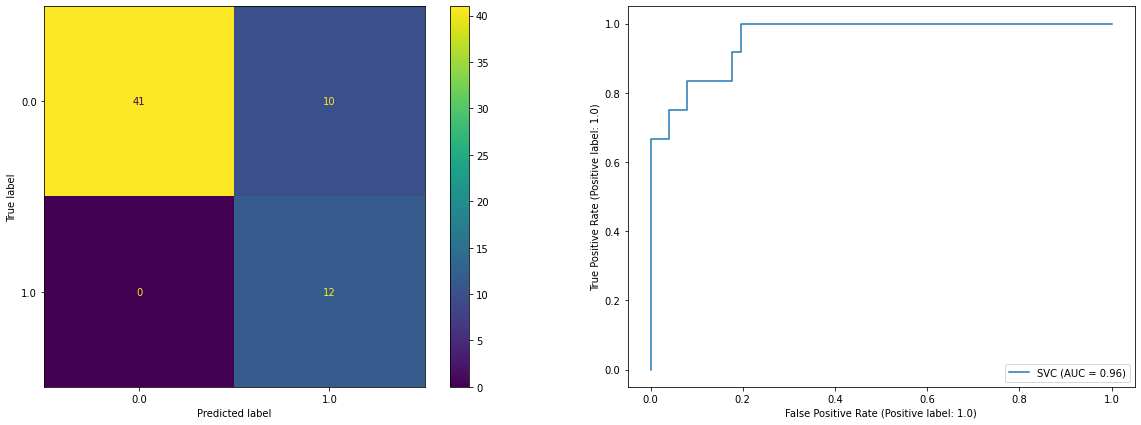

In [91]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))
plot_confusion_matrix(svc_model, Test_x, Test_y, ax=axes[0])
plot_roc_curve(svc_model, Test_x, Test_y, ax=axes[1]);

## 3- Decision Trees

In [92]:
Train_x.shape

(279, 31)

In [93]:
from sklearn.tree import DecisionTreeClassifier

In [94]:
tree_Train_results = pd.DataFrame(columns=['Max_Depth', 'Max_Features', 'Max_Leaf_Nodes', 'Min_sample_split', 'CCP_Alpha', 'Precision', 'Recall', 'F1-Score', 'Accuracy'])

In [95]:
tree_Test_results = pd.DataFrame(columns=['Max_Depth', 'Max_Features', 'Max_Leaf_Nodes', 'Min_sample_split', 'CCP_Alpha', 'Precision', 'Recall', 'F1-Score', 'Accuracy'])

In [96]:
max_depth = [3, 5, 7, 9, 12]
max_features = [2, 4, 8, 16, 24, 31]
max_leaf_nodes = [10, 20, 30, 40, 50]
min_sample_split = [4, 8, 16, 24]
cc_alpha = [.001, .005, .01, .015, .02, .025, .03]

for d in max_depth:
    for mf in max_features:
        for mss in min_sample_split:
            for mln in max_leaf_nodes:
                for cca in cc_alpha:
                    DTC = DecisionTreeClassifier(max_depth=d, max_features=mf, max_leaf_nodes=mln,
                                                class_weight='balanced', min_samples_split=mss, ccp_alpha=cca)
                    
                    DTC.fit(Train_x, Train_y)

                    # tree train y pred
                    tree_y_train = DTC.predict(Train_x)

                    # test test y pred
                    tree_y_test = DTC.predict(Test_x)

                    # Precision
                    tree_train_precision = precision_score(Train_y, tree_y_train)
                    tree_test_precision = precision_score(Test_y, tree_y_test)

                    # Recall
                    tree_train_recall = recall_score(Train_y, tree_y_train)
                    tree_test_recall = recall_score(Test_y, tree_y_test)

                    # F1 score
                    tree_train_f1 = f1_score(Train_y, tree_y_train)
                    tree_test_f1 = f1_score(Test_y, tree_y_test)

                    # Accuracy
                    tree_train_accuracy = accuracy_score(Train_y, tree_y_train)
                    tree_test_accuracy = accuracy_score(Test_y, tree_y_test)

                    # append train results to train results df
                    tree_Train_results.loc[-1] = [d, mf, mln, mss, cca, tree_train_precision, tree_train_recall, tree_train_f1, tree_train_accuracy]
                    tree_Train_results.index = tree_Train_results.index + 1  # shifting index
                    tree_Train_results = tree_Train_results.sort_index()

                    # append test results to test results df
                    tree_Test_results.loc[-1] = [d, mf, mln, mss, cca, tree_test_precision, tree_test_recall, tree_test_f1, tree_test_accuracy]
                    tree_Test_results.index = tree_Test_results.index + 1  # shifting index
                    tree_Test_results = tree_Test_results.sort_index()

In [97]:
tree_Train_results.sort_values(['F1-Score', 'Precision'], ascending=False).head()

,Max_Depth,Max_Features,Max_Leaf_Nodes,Min_sample_split,CCP_Alpha,Precision,Recall,F1-Score,Accuracy
111,12.0,31.0,50.0,4.0,0.001,1.000000,1.0,1.000000,1.000000
118,12.0,31.0,40.0,4.0,0.001,1.000000,1.0,1.000000,1.000000
125,12.0,31.0,30.0,4.0,0.001,1.000000,1.0,1.000000,1.000000
258,12.0,24.0,40.0,4.0,0.001,1.000000,1.0,1.000000,1.000000
398,12.0,16.0,40.0,4.0,0.001,0.980769,1.0,0.990291,0.996416


In [98]:
tree_Test_results.sort_values(['F1-Score', 'Precision'], ascending=False).head()

,Max_Depth,Max_Features,Max_Leaf_Nodes,Min_sample_split,CCP_Alpha,Precision,Recall,F1-Score,Accuracy
3215,5.0,4.0,10.0,4.0,0.020,0.692308,0.750000,0.720000,0.888889
2067,7.0,16.0,50.0,4.0,0.020,0.642857,0.750000,0.692308,0.873016
3873,3.0,8.0,20.0,8.0,0.020,0.642857,0.750000,0.692308,0.873016
3275,5.0,2.0,30.0,16.0,0.001,0.550000,0.916667,0.687500,0.841270
711,12.0,2.0,40.0,24.0,0.010,0.555556,0.833333,0.666667,0.841270


> Best Model ROC

In [99]:
DTC_model = DecisionTreeClassifier(max_depth=5, max_features=4, max_leaf_nodes=10, min_samples_split=4, ccp_alpha=.02, class_weight='balanced')
DTC_model.fit(Train_x, Train_y)

DecisionTreeClassifier(ccp_alpha=0.02, class_weight='balanced', max_depth=5,
                       max_features=4, max_leaf_nodes=10, min_samples_split=4)

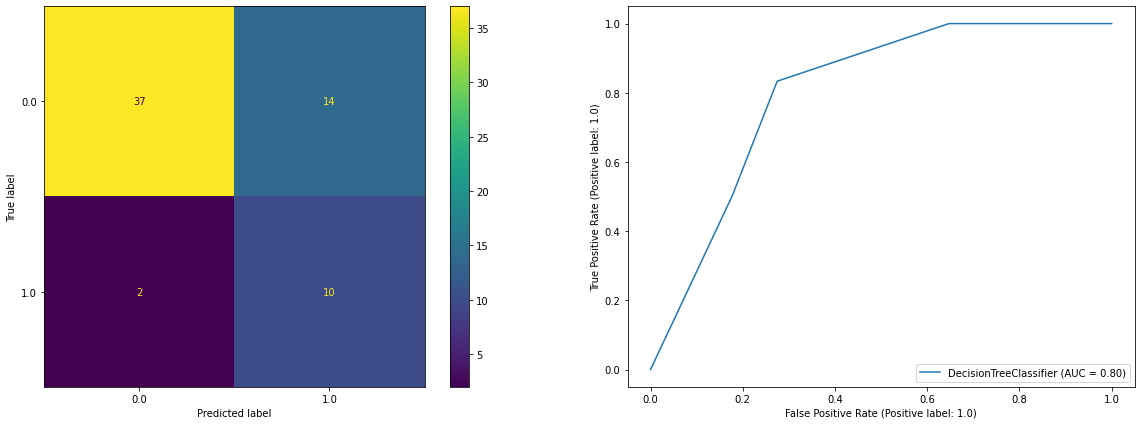

In [100]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))
plot_confusion_matrix(DTC_model, Test_x, Test_y, ax=axes[0])
plot_roc_curve(DTC_model, Test_x, Test_y, ax=axes[1]);

## 4- KNN

In [101]:
from sklearn.neighbors import KNeighborsClassifier

In [102]:
knn_Train_results = pd.DataFrame(columns=['N_Neighbors', 'Weights', 'Metric', 'Precision', 'Recall', 'F1-Score', 'Accuracy'])

In [103]:
knn_Test_results = pd.DataFrame(columns=['N_Neighbors', 'Weights', 'Metric', 'Precision', 'Recall', 'F1-Score', 'Accuracy'])

In [104]:
n_neighbors = [3, 5, 7, 9, 10, 15, 20]
weights = ['uniform', 'distance']
metrics = ['euclidean', 'manhattan', 'minkowski']

for n in n_neighbors:
    for w in weights:
        for m in metrics:
            knn = KNeighborsClassifier(n_neighbors=n, weights=w, metric=m)
            knn.fit(Train_x, Train_y)

            # knn train y pred
            knn_Train_y = knn.predict(Train_x)

            # knn test y pred
            knn_Test_y = knn.predict(Test_x)

            # Precision
            knn_train_precision = precision_score(Train_y, knn_Train_y)
            knn_test_precision = precision_score(Test_y, knn_Test_y)

            # Recall
            knn_train_recall = recall_score(Train_y, knn_Train_y)
            knn_test_recall = recall_score(Test_y, knn_Test_y)

            # F1 score
            knn_train_f1 = f1_score(Train_y, knn_Train_y)
            knn_test_f1 = f1_score(Test_y, knn_Test_y)

            # Accuracy
            knn_train_accuracy = accuracy_score(Train_y, knn_Train_y)
            knn_test_accuracy = accuracy_score(Test_y, knn_Test_y)


            # append train results to train results df
            knn_Train_results.loc[-1] = [n, w, m, knn_train_precision, knn_train_recall, knn_train_f1, knn_train_accuracy]
            knn_Train_results.index = knn_Train_results.index + 1  # shifting index
            knn_Train_results = knn_Train_results.sort_index()

            # append test results to test results df
            knn_Test_results.loc[-1] = [n, w, m, knn_test_precision, knn_test_recall, knn_test_f1, knn_test_accuracy]
            knn_Test_results.index = knn_Test_results.index + 1  # shifting index
            knn_Test_results = knn_Test_results.sort_index()

In [105]:
knn_Train_results.sort_values(['F1-Score', 'Precision'], ascending=False).head()

,N_Neighbors,Weights,Metric,Precision,Recall,F1-Score,Accuracy
0,20,distance,minkowski,1.0,1.0,1.0,1.0
1,20,distance,manhattan,1.0,1.0,1.0,1.0
2,20,distance,euclidean,1.0,1.0,1.0,1.0
6,15,distance,minkowski,1.0,1.0,1.0,1.0
7,15,distance,manhattan,1.0,1.0,1.0,1.0


In [106]:
knn_Test_results.sort_values(['Recall', 'Precision'], ascending=False).head()

,N_Neighbors,Weights,Metric,Precision,Recall,F1-Score,Accuracy
0,20,distance,minkowski,0.833333,0.416667,0.555556,0.873016
2,20,distance,euclidean,0.833333,0.416667,0.555556,0.873016
19,9,distance,manhattan,0.833333,0.416667,0.555556,0.873016
22,9,uniform,manhattan,0.833333,0.416667,0.555556,0.873016
1,20,distance,manhattan,0.714286,0.416667,0.526316,0.857143


> Best Model ROC

In [107]:
KNN_model = KNeighborsClassifier(n_neighbors=20, weights='distance', metric='minkowski')
KNN_model.fit(Train_x, Train_y)

KNeighborsClassifier(n_neighbors=20, weights='distance')

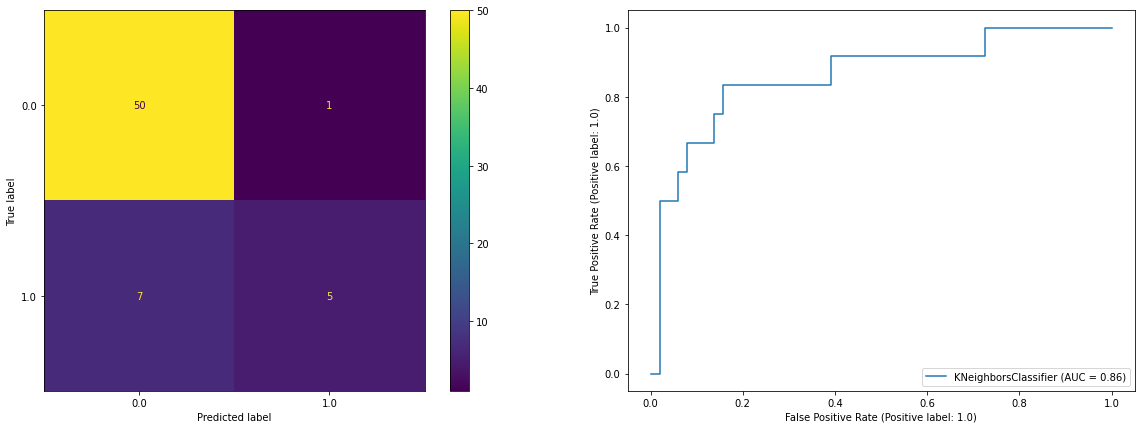

In [108]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))
plot_confusion_matrix(KNN_model, Test_x, Test_y, ax=axes[0])
plot_roc_curve(KNN_model, Test_x, Test_y, ax=axes[1]);

## Final conclusion

In [115]:
Final_Results = pd.DataFrame(columns=['Model', 'AUC', 'Precision', 'Recall', 'F1-Score', 'Accuracy'])

In [116]:
Final_Results.loc[-1] = ['Logistic', .93] + Test_results.sort_values(['F1-Score', 'Precision'], ascending=False).head(1).iloc[:, -4:].values.tolist()[0]
Final_Results.index = Final_Results.index + 1  # shifting index
Final_Results = Final_Results.sort_index()

In [117]:
Final_Results.loc[-1] = ['SVC', .96] + svc_Test_results.sort_values(['F1-Score', 'Precision'], ascending=False).head(1).iloc[:, -4:].values.tolist()[0]
Final_Results.index = Final_Results.index + 1  # shifting index
Final_Results = Final_Results.sort_index()

In [118]:
Final_Results.loc[-1] = ['Tree', .8] + tree_Test_results.sort_values(['F1-Score', 'Precision'], ascending=False).head(1).iloc[:, -4:].values.tolist()[0]
Final_Results.index = Final_Results.index + 1  # shifting index
Final_Results = Final_Results.sort_index()

In [119]:
Final_Results.loc[-1] = ['KNN', .86] + knn_Test_results.sort_values(['F1-Score', 'Precision'], ascending=False).head(1).iloc[:, -4:].values.tolist()[0]
Final_Results.index = Final_Results.index + 1  # shifting index
Final_Results = Final_Results.sort_index()

In [120]:
Final_Results.sort_values(['F1-Score', 'Recall'], ascending=False)

,Model,AUC,Precision,Recall,F1-Score,Accuracy
1,Tree,0.80,0.692308,0.750000,0.720000,0.888889
2,SVC,0.96,0.545455,1.000000,0.705882,0.841270
3,Logistic,0.93,0.500000,0.916667,0.647059,0.809524
0,KNN,0.86,0.833333,0.416667,0.555556,0.873016


> SVC has the largest AUC  so it the best model as it made the lowest missclassification 